## Install required libraries

In [1]:
# install imbalanced-learn package
!pip install imbalanced-learn==0.11.0
!pip install xgboost

     |████████████████████████████████| 235 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 2.9 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 0.16.0
    Uninstalling joblib-0.16.0:
      Successfully uninstalled joblib-0.16.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1
     |████████████████████████████████| 2.2 MB 2.0 MB/s eta 0:00:01


## Import required libraries/packages

In [21]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import xgboost as xgb
import imblearn
import matplotlib.pyplot as plt
import matplotlib.axes as axes

from scipy import integrate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, classification_report, precision_recall_fscore_support, confusion_matrix, precision_recall_curve, f1_score, PrecisionRecallDisplay, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

## Define functions

In [22]:
def grid_search_dt(X_train, y_train, metric):
    params_grid = {'max_depth': [5, 10, 20],
                   'class_weight': [{0: 0.95, 1: 0.05}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}],
                   'min_samples_split': [2, 5, 10]}
    r = 20
    dt = DecisionTreeClassifier(criterion='gini', random_state=r)
    grid_search = GridSearchCV(estimator=dt,
                               param_grid=params_grid,
                               scoring=metric,
                               cv=5,
                               verbose=3,
                               n_jobs=-2)
    grid_search.fit(X_train, y_train)
    best_est = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results = grid_search.cv_results_
    return best_est, best_par, best_score, cv_results


def grid_search_rf(X_train, y_train, metric):
    y_train = y_train.to_numpy().ravel()
    params_grid = {'max_depth': [5, 10, 20],
                   'class_weight': [{0: 0.95, 1: 0.05}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}],
                   'n_estimators': [10, 50, 100],
                   'max_features': ['sqrt', 'log2']}
    r = 20
    rf = RandomForestClassifier(random_state=r)
    grid_search = GridSearchCV(estimator=rf, param_grid=params_grid, scoring=metric, cv=5, verbose=3, n_jobs=-2)
    grid_search.fit(X_train, y_train)
    best_est = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results = grid_search.cv_results_
    return best_est, best_par, best_score, cv_results


def grid_search_gb(X_train, y_train, metric):
    y_train = y_train.to_numpy().ravel()
    params_grid = {'learning_rate': [0.05, 0.1, 0.5],
                   'n_estimators': [50, 100],
                   'max_depth': [10, 20],
                   'max_features': ['sqrt', 'log2'],
                   'subsample': [0.5, 1]}
    r = 20
    gb = GradientBoostingClassifier(random_state=r)
    grid_search = GridSearchCV(estimator=gb, param_grid=params_grid, scoring=metric, cv=5, verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_est = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results = grid_search.cv_results_
    return best_est, best_par, best_score, cv_results


def auc2(fpr_list, tpr_list):
    sorted_index = np.argsort(fpr_list)
    fpr_list_sorted = np.array(fpr_list)[sorted_index]
    tpr_list_sorted = np.array(tpr_list)[sorted_index]
    return integrate.trapz(y=tpr_list_sorted, x=fpr_list_sorted)

## Load in dataset

In [23]:
credit_data = pd.read_csv("creditcard.csv")
credit_data.shape
#print(credit_data.head(10))

(284807, 31)

In [24]:
credit_data.isna()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
284803,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
284804,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
284805,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Drop any NA values

In [25]:
credit_data.dropna(inplace=True)
credit_data.shape

(284807, 31)

In [26]:
credit_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [27]:
credit_data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Split the dataset

In [28]:
X = credit_data.loc[:, credit_data.columns != 'Class']
y = credit_data.loc[:, credit_data.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20)

In [29]:
y_train.value_counts()

Class
0        227451
1           394
dtype: int64

In [30]:
y_test.value_counts()

Class
0        56864
1           98
dtype: int64

### Balance the dataset using SMOTE

<AxesSubplot:title={'center':'SMOTE'}, xlabel='Class'>

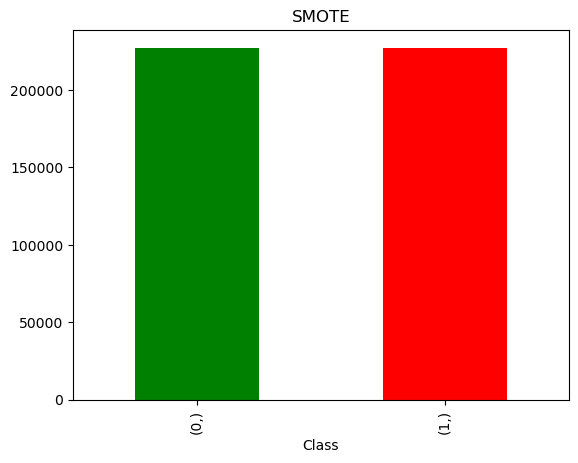

In [31]:
smote_sampler = SMOTE(random_state=20)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

y_smo.value_counts().plot.bar(color=['green', 'red'], title='SMOTE')

### Balance the dataset using ADASYN

<AxesSubplot:title={'center':'ADASYN'}, xlabel='Class'>

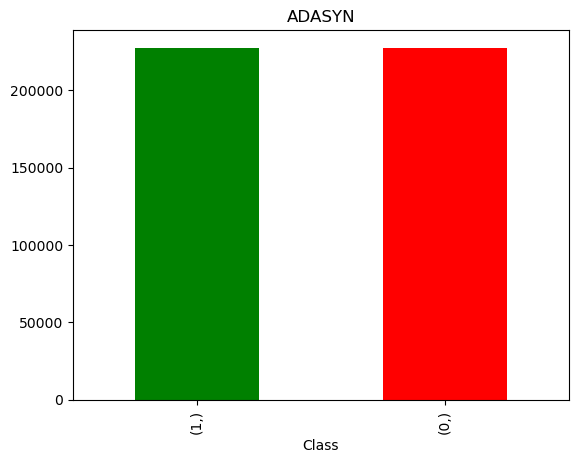

In [32]:
adasyn_sampler = ADASYN(random_state=20)
X_ada, y_ada = adasyn_sampler.fit_resample(X_train, y_train)

y_ada.value_counts().plot.bar(color=['green', 'red'], title='ADASYN')

### Balance the dataset using SMOTE-ENN

Class
0        227451
1        227451
dtype: int64

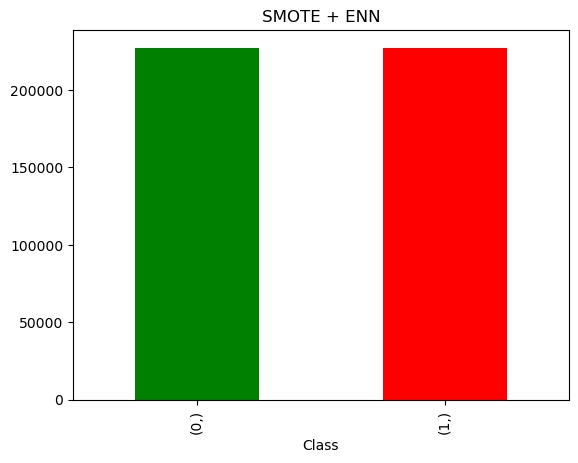

In [33]:
st = SMOTE(k_neighbors=NearestNeighbors(n_neighbors=5, algorithm='kd_tree', n_jobs=-1), random_state=20)
X_st, y_st = st.fit_resample(X_smo, y_smo)

y_st.value_counts().plot.bar(color=['green', 'red'], title='SMOTE + ENN')

### Balance the dataset using Random Undersampling

<AxesSubplot:title={'center':'Random Undersampling'}, xlabel='Class'>

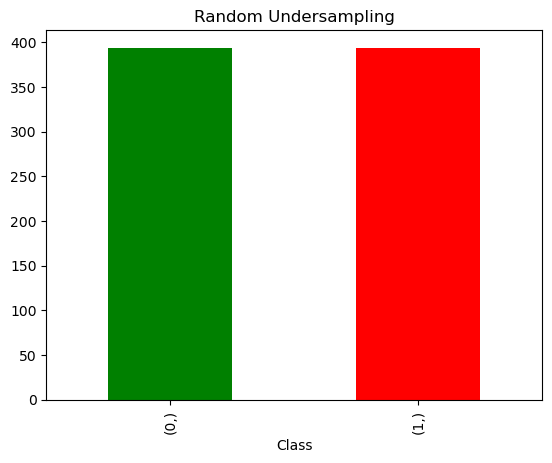

In [34]:
ru = RandomUnderSampler(sampling_strategy='auto')
X_ru, y_ru = ru.fit_resample(X_train, y_train)

y_ru.value_counts().plot.bar(color=['green', 'red'], title='Random Undersampling')

## Analyze confusion matrices of best decision trees

Using the 5 best decision trees from the "Find the best decision tree for each training set" section of "CreditCardFraud_Recall_GridSearchCV", plot their confusion matrices to see the Type 1 and Type 2 error for each training set (Non-balanced, SMOTE, ADSYN, SMOTE+ENN, and Random Undersampling).

In [ ]:
cw = [{0: 0.8, 1: 0.2}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.95, 1: 0.05}, {0: 0.9, 1: 0.1}]
md = [20, 20, 20, 20, 20]
mss = [2, 2, 5, 2, 5]
r = 20
for i in range(5):
    print('GridSearchCV Rank: ', i+1)
    print('DecisionTreeClassifier(class_weight=', cw[i], ', max_depth=', md[i], ', min_samples_split=', mss[i], ', random_state=', r, ')')
    print()
    print('No Balancing')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred))
    print('Precision = ', precision_score(y_test, y_pred))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('SMOTE')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_smo, y_smo)
    y_pred_smo = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_smo))
    print('Precision = ', precision_score(y_test, y_pred_smo))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_smo), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('ADASYN')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_ada, y_ada)
    y_pred_ada = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_ada))
    print('Precision = ', precision_score(y_test, y_pred_ada))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('SMOTE+ENN')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_st, y_st)
    y_pred_st = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_st))
    print('Precision = ', precision_score(y_test, y_pred_st))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_st), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('Random Undersampling')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_ru, y_ru)
    y_pred_ru = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_ru))
    print('Precision = ', precision_score(y_test, y_pred_ru))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_ru), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print()
    print()

GridSearchCV Rank:  1
DecisionTreeClassifier(class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , min_samples_split= 2 , random_state= 20 )

No Balancing
Recall =  0.7346938775510204
Precision =  0.7578947368421053

SMOTE


KeyboardInterrupt: 

Recall =  0.8163265306122449
Precision =  0.35714285714285715

ADASYN
Recall =  0.8163265306122449
Precision =  0.35398230088495575

SMOTE+ENN


## Analyze confusion matrices of best Random Forest models

Using the 5 best random forest models from the "Find the best Random Forest for each training set" section of "CreditCardFraud_Recall_GridSearchCV", plot their confusion matrices to see the Type 1 and Type 2 error for each training set (Non-balanced, SMOTE, ADSYN, SMOTE+ENN, and Random Undersampling).

GridSearchCV Rank:  1
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= 2 , random_state= 20 )

No Balancing
Recall =  0.75
Precision =  0.8181818181818182

SMOTE
Recall =  0.7708333333333334
Precision =  0.4111111111111111

ADASYN
Recall =  0.7916666666666666
Precision =  0.3917525773195876

SMOTE+Tomek
Recall =  0.8125
Precision =  0.42857142857142855

Random Undersampling
Recall =  0.8958333333333334
Precision =  0.016226415094339624



GridSearchCV Rank:  2
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= 2 , random_state= 20 )

No Balancing
Recall =  0.75
Precision =  0.8181818181818182

SMOTE
Recall =  0.7708333333333334
Precision =  0.4111111111111111

ADASYN
Recall =  0.7916666666666666
Precision =  0.3917525773195876

SMOTE+Tomek
Recall =  0.8125
Precision =  0.42857142857142855

Random Undersampling
Recall =  0.8958333333333334
Precision =  0.016226415094339624



GridS

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


Recall =  0.7708333333333334
Precision =  0.4111111111111111

ADASYN
Recall =  0.7916666666666666
Precision =  0.3917525773195876

SMOTE+Tomek
Recall =  0.8125
Precision =  0.42857142857142855

Random Undersampling
Recall =  0.8958333333333334
Precision =  0.016226415094339624





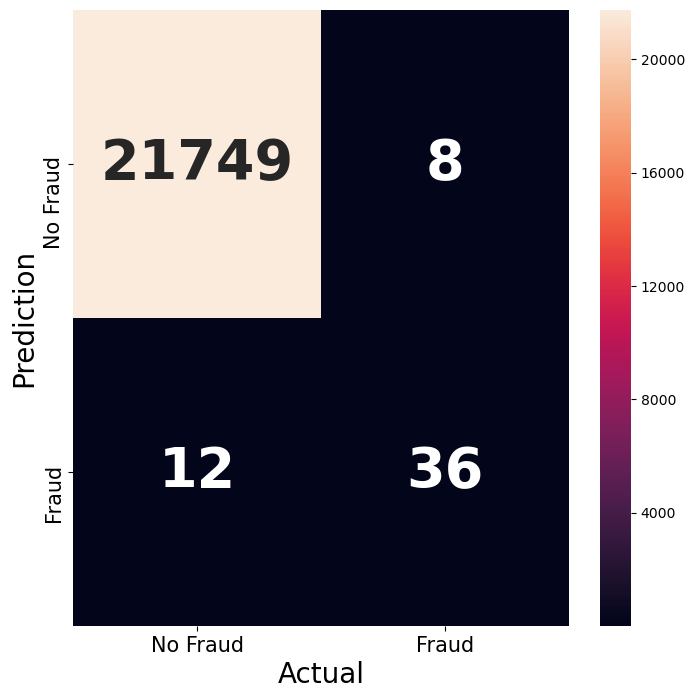

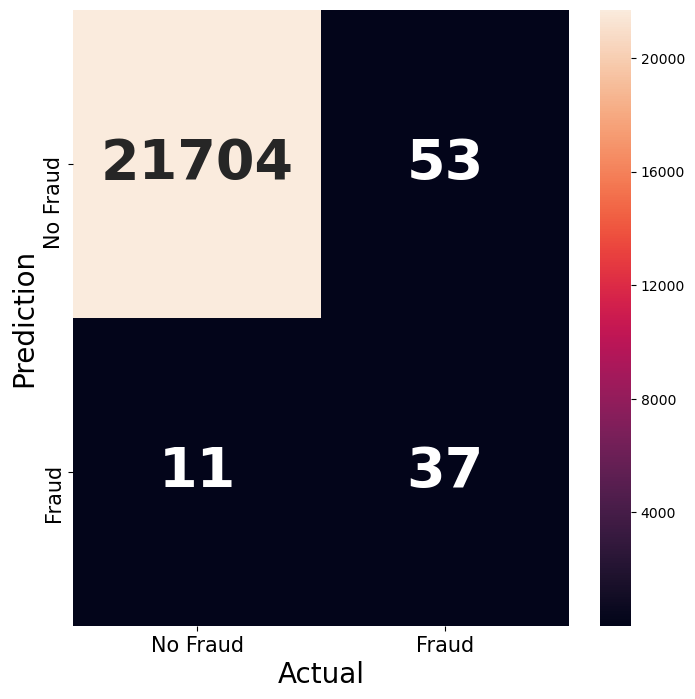

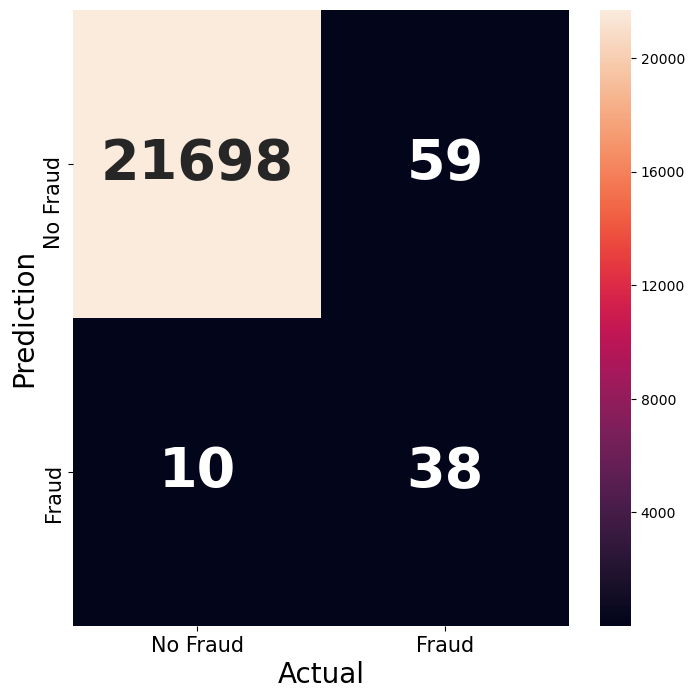

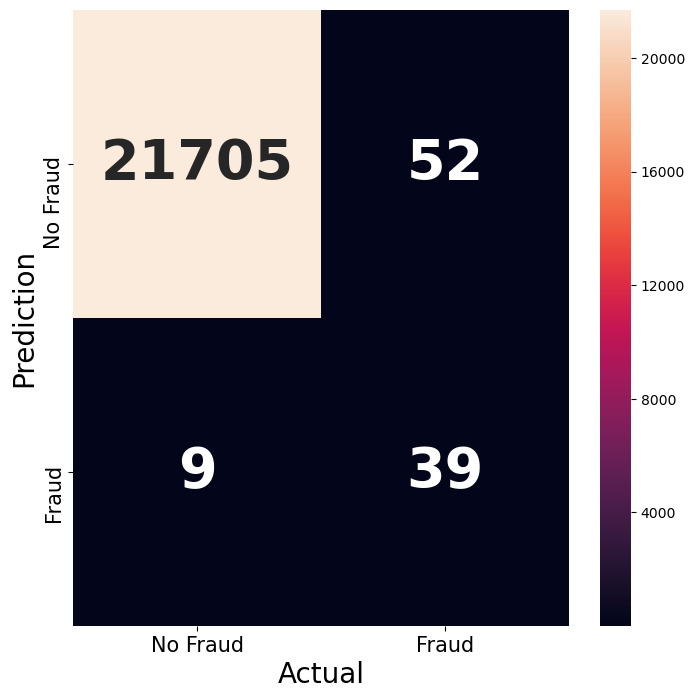

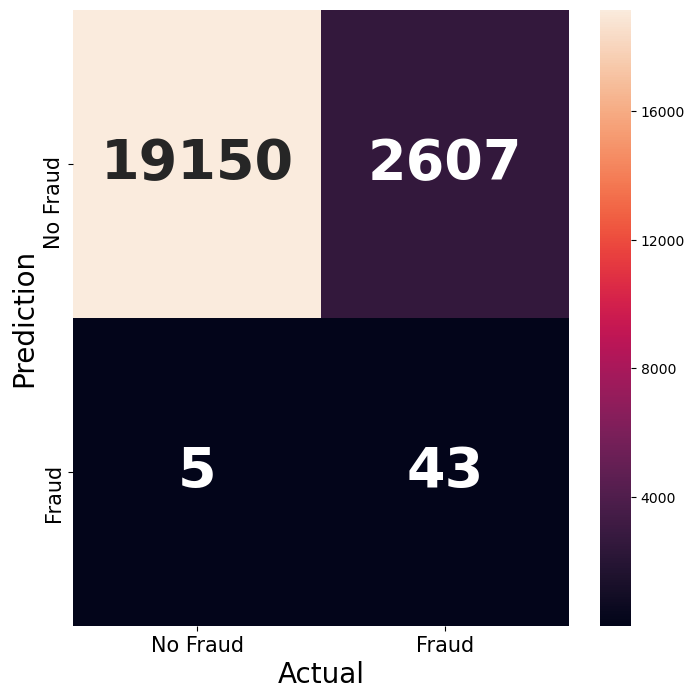

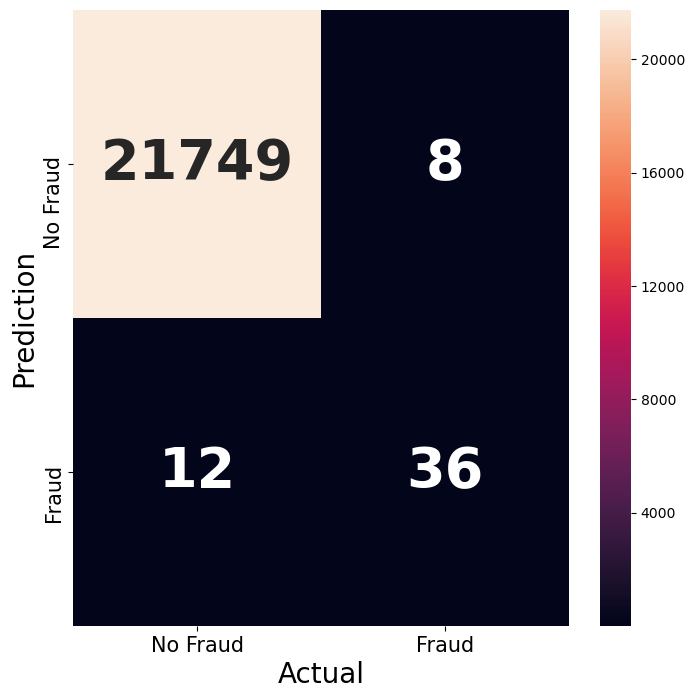

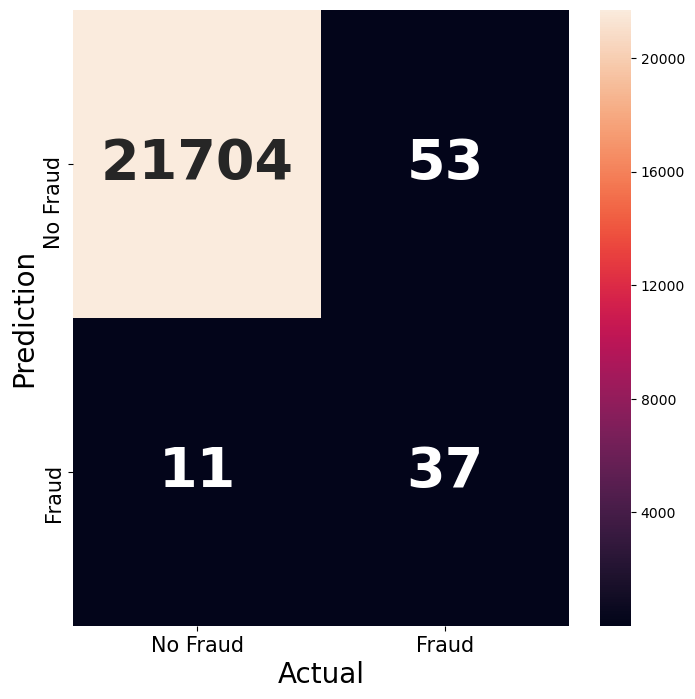

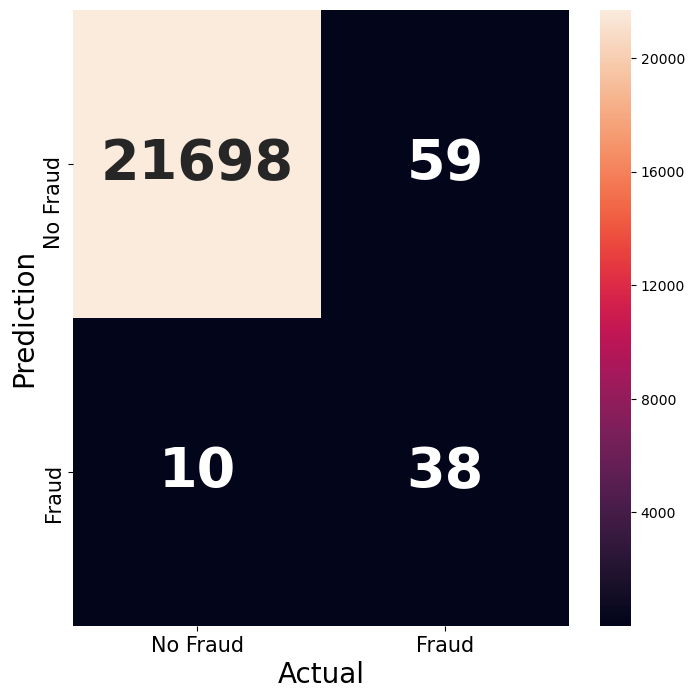

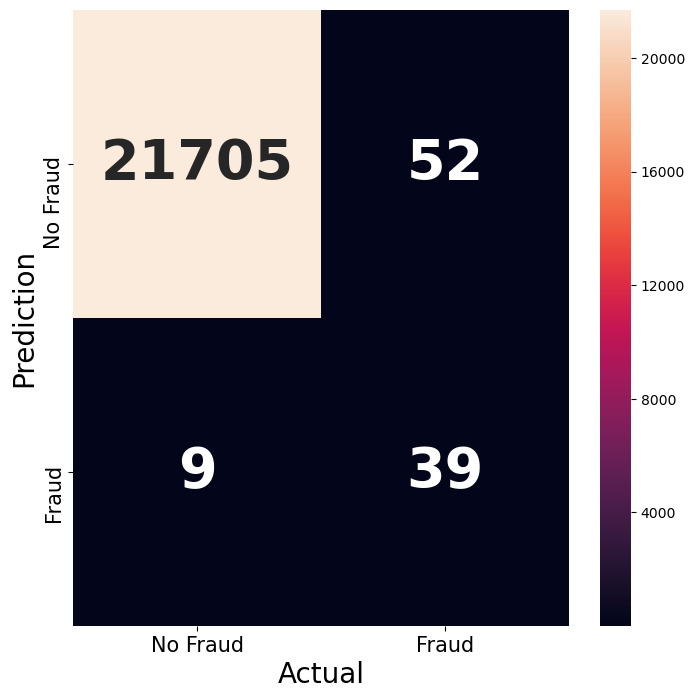

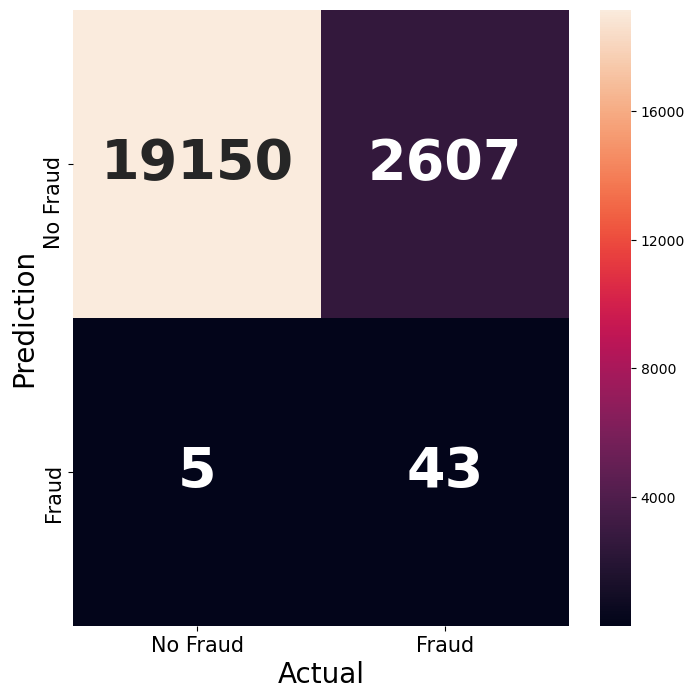

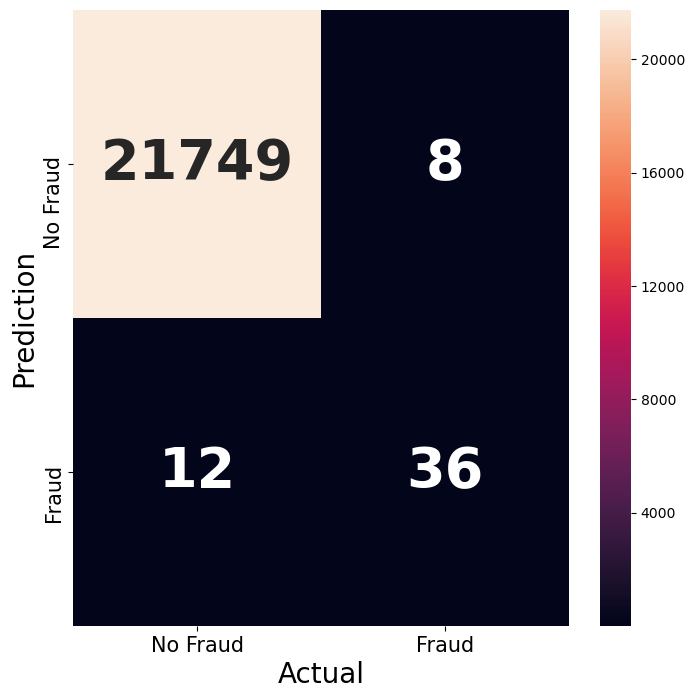

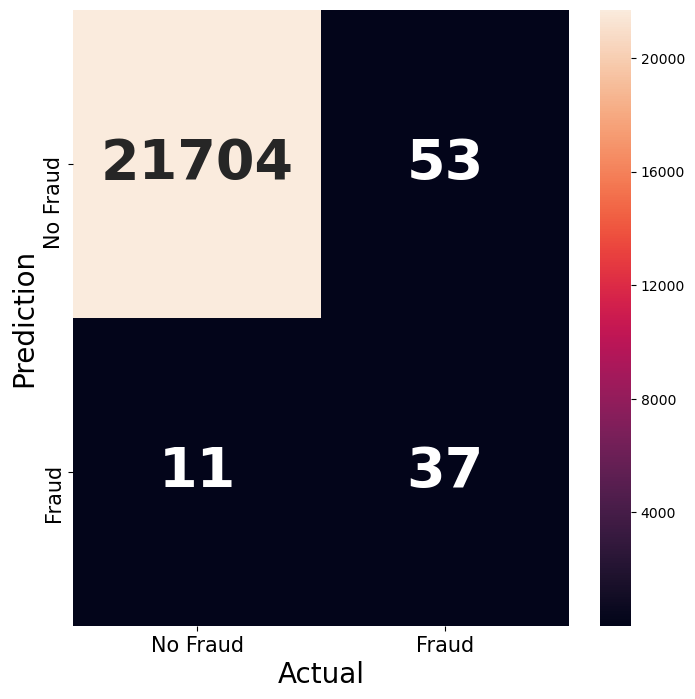

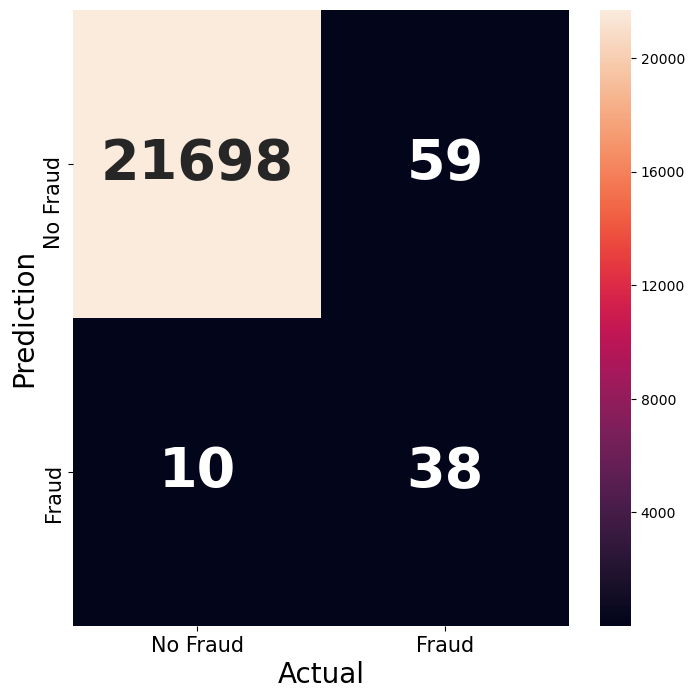

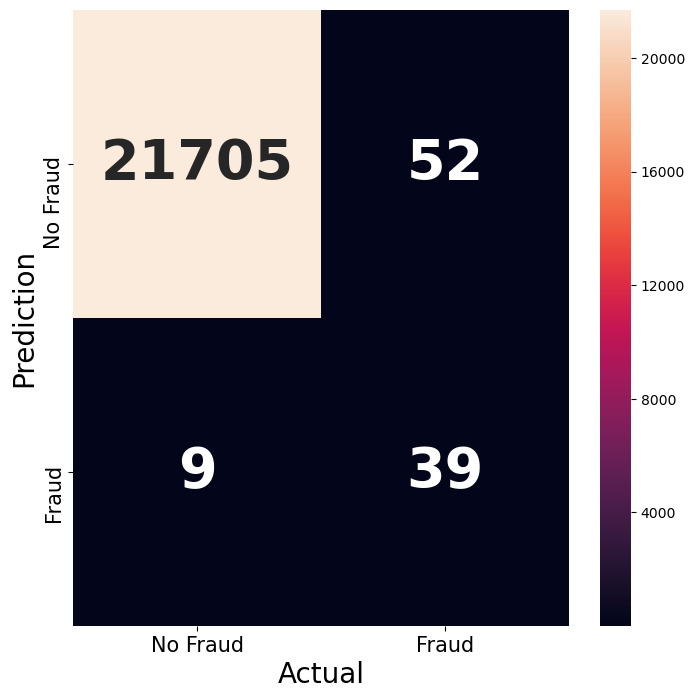

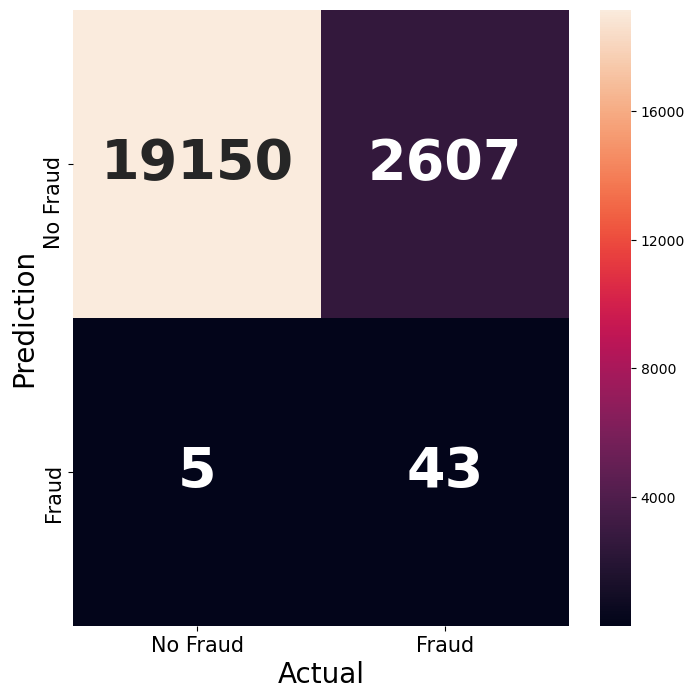

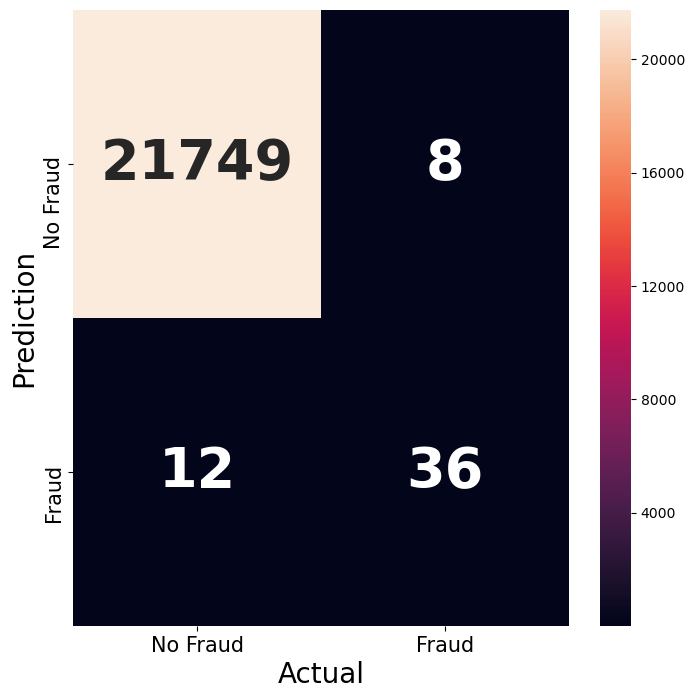

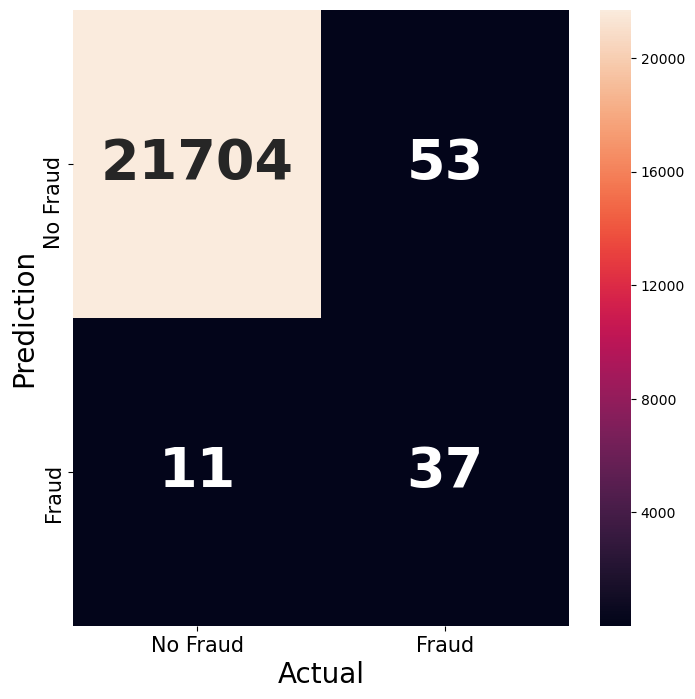

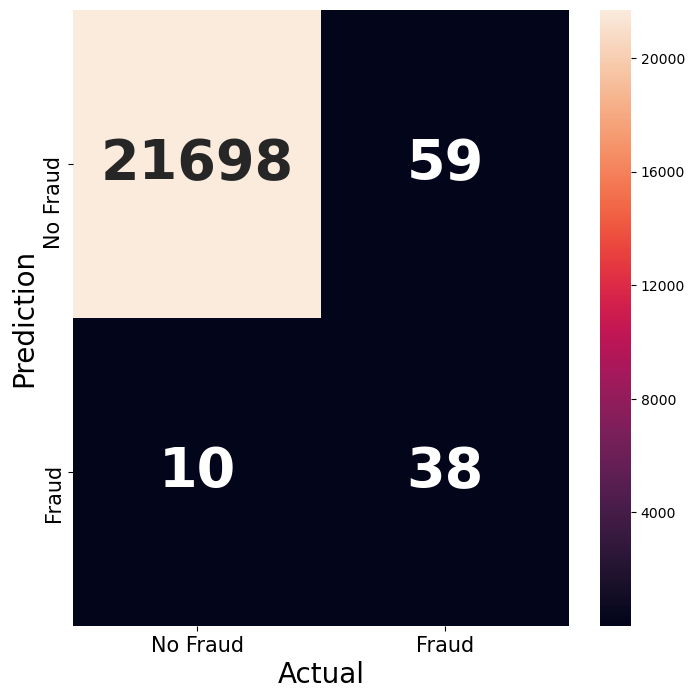

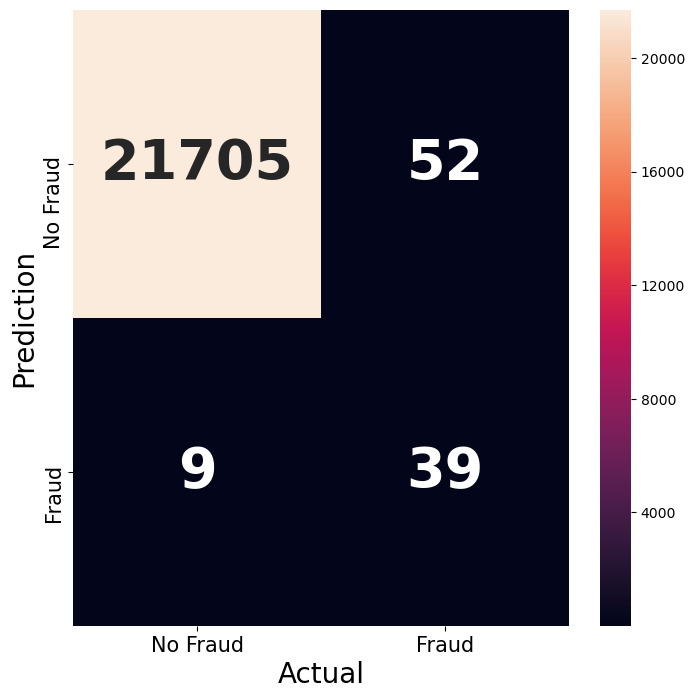

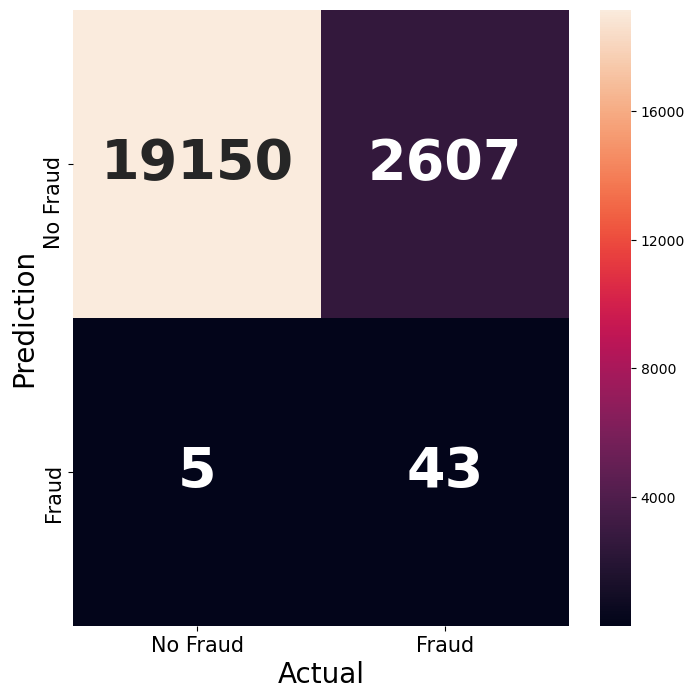

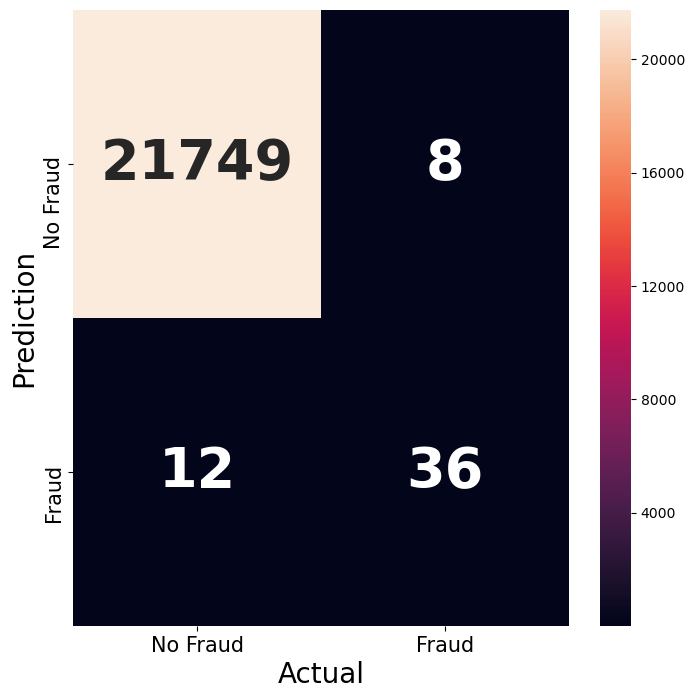

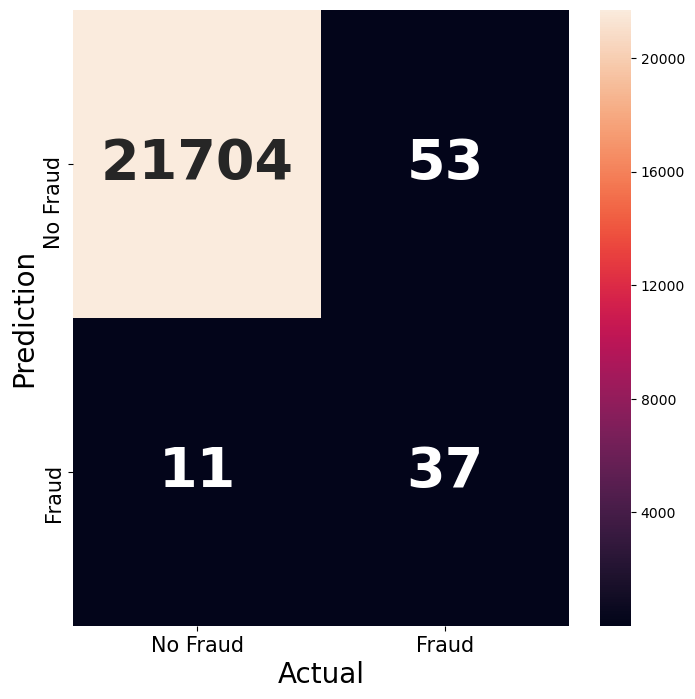

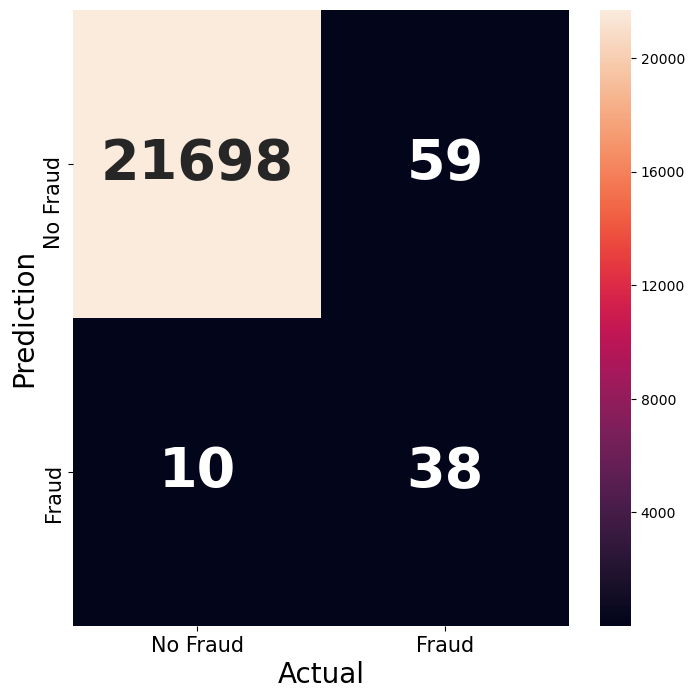

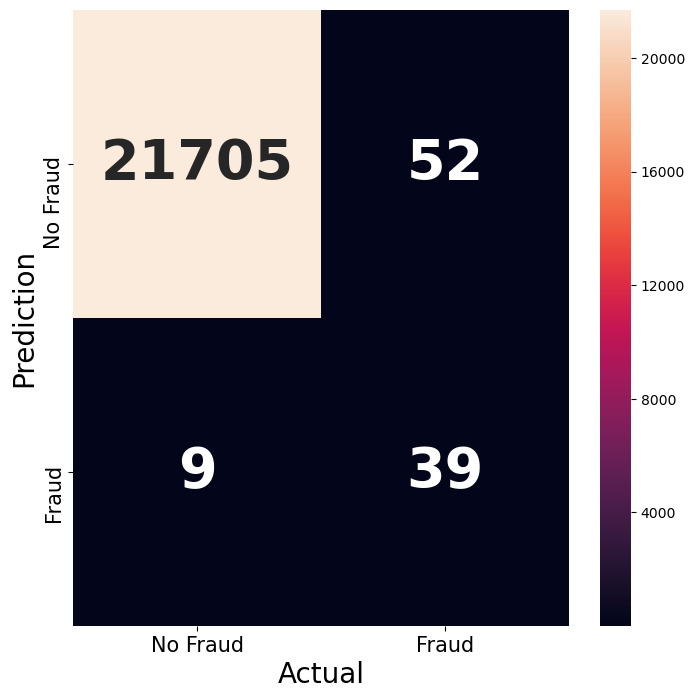

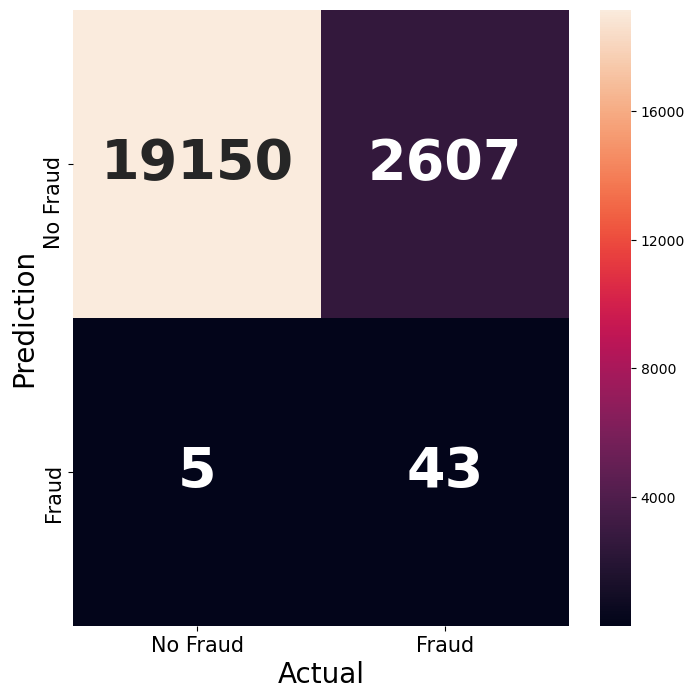

In [30]:
cw = [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.8, 1: 0.2}, {0: 0.8, 1: 0.2}, {0: 0.95, 1: 0.05}]
md = [20, 20, 20, 20, 10]
mf = ['sqrt', 'sqrt', 'sqrt', 'log2', 'sqrt']
ne = [100, 50, 100, 100, 10]
r = 20
for i in range(5):
    print('GridSearchCV Rank: ', i+1)
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mss[i], ', random_state=', r, ')')
    print()
    print('No Balancing')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred))
    print('Precision = ', precision_score(y_test, y_pred))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('SMOTE')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_smo, y_smo)
    y_pred_smo = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_smo))
    print('Precision = ', precision_score(y_test, y_pred_smo))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_smo), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('ADASYN')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_ada, y_ada)
    y_pred_ada = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_ada))
    print('Precision = ', precision_score(y_test, y_pred_ada))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('SMOTE+Tomek')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_st, y_st)
    y_pred_st = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_st))
    print('Precision = ', precision_score(y_test, y_pred_st))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_st), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('Random Undersampling')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_ru, y_ru)
    y_pred_ru = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_ru))
    print('Precision = ', precision_score(y_test, y_pred_ru))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_ru), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print()
    print()

## Analyze confusion matrices for best Gradient Boosting Tree models

Using the 5 best random forest models from the "Find the best Gradient Boosting Classifier for each training set" section of "CreditCardFraud_Recall_GridSearchCV", plot their confusion matrices to see the Type 1 and Type 2 error for each training set (Non-balanced, SMOTE, ADSYN, SMOTE+ENN, and Random Undersampling).

GridSearchCV Rank:  1
GradientBoostingClassifier(n_estimators= 50 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= 2 , random_state= 20 )

No Balancing
Recall =  0.75
Precision =  0.8181818181818182

SMOTE
Recall =  0.7708333333333334
Precision =  0.4111111111111111

ADASYN
Recall =  0.7916666666666666
Precision =  0.3917525773195876

SMOTE+Tomek
Recall =  0.8125
Precision =  0.42857142857142855

Random Undersampling
Recall =  0.8958333333333334
Precision =  0.016226415094339624



GridSearchCV Rank:  2
GradientBoostingClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= 2 , random_state= 20 )

No Balancing
Recall =  0.75
Precision =  0.8181818181818182

SMOTE
Recall =  0.7708333333333334
Precision =  0.4111111111111111

ADASYN
Recall =  0.7916666666666666
Precision =  0.3917525773195876

SMOTE+Tomek
Recall =  0.8125
Precision =  0.42857142857142855

Random Undersampling
Recall =  0.8958333333333334
Precision =  0.016226415094339624


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


Recall =  0.7708333333333334
Precision =  0.4111111111111111

ADASYN
Recall =  0.7916666666666666
Precision =  0.3917525773195876

SMOTE+Tomek
Recall =  0.8125
Precision =  0.42857142857142855

Random Undersampling
Recall =  0.8958333333333334
Precision =  0.016226415094339624





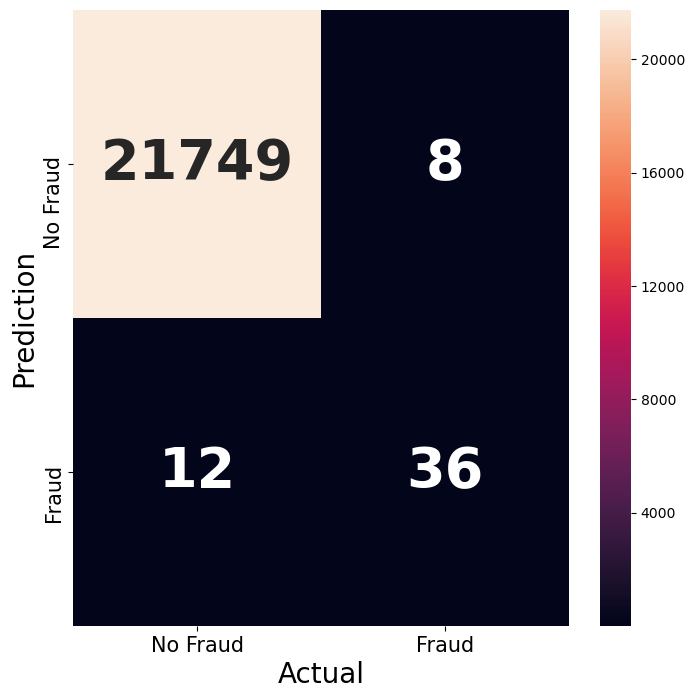

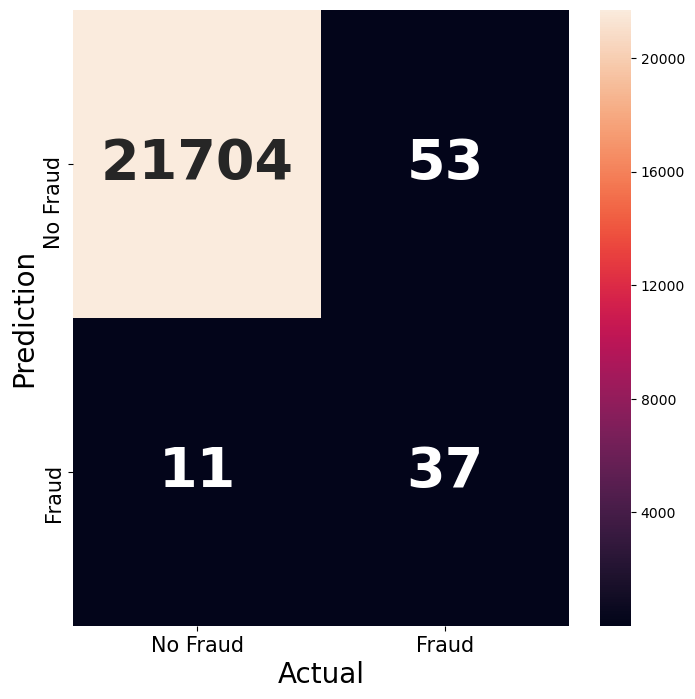

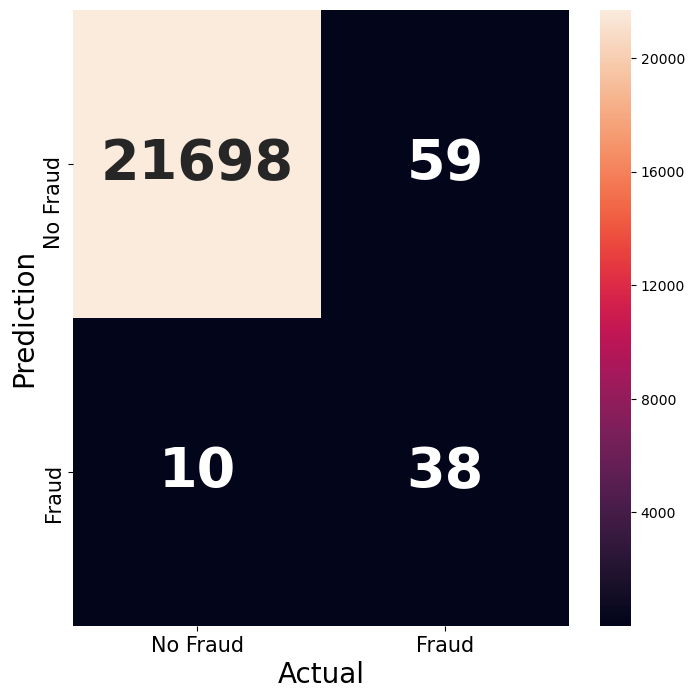

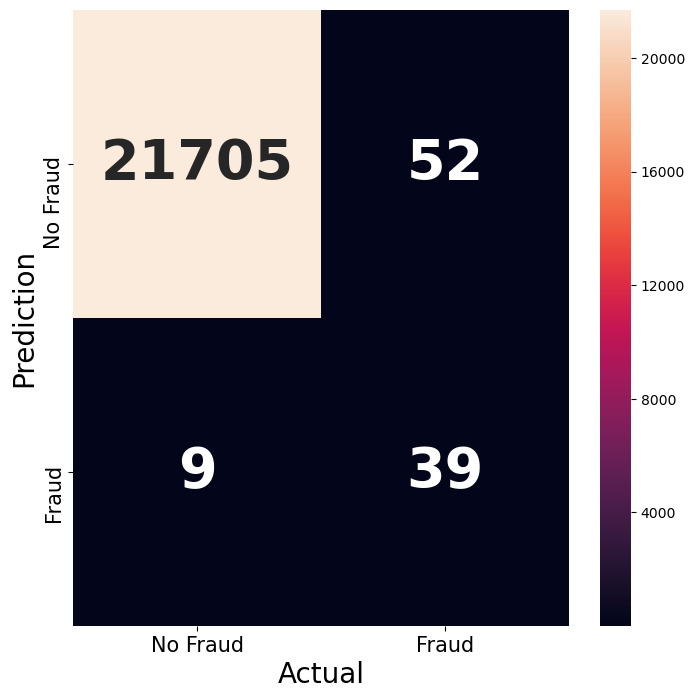

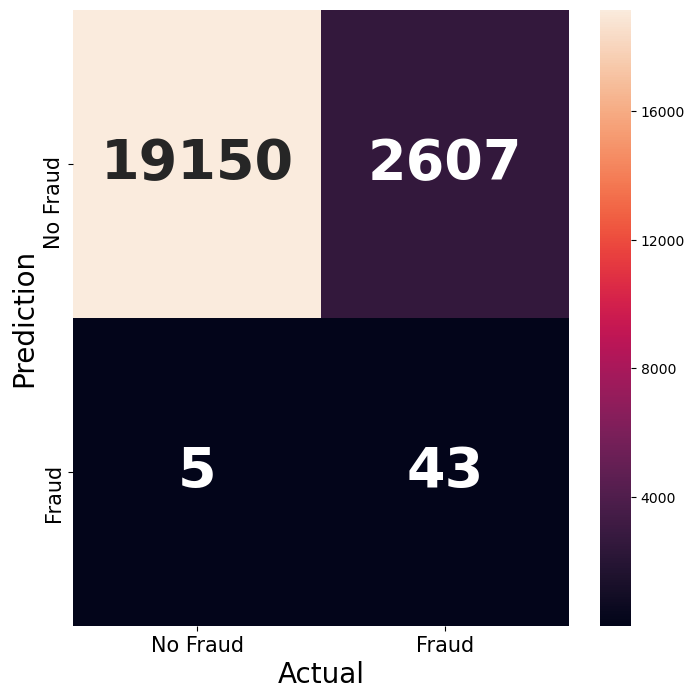

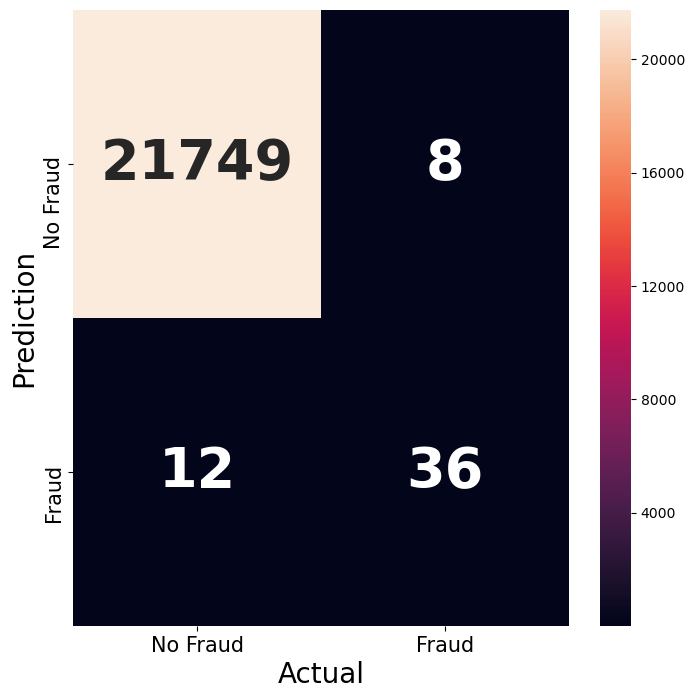

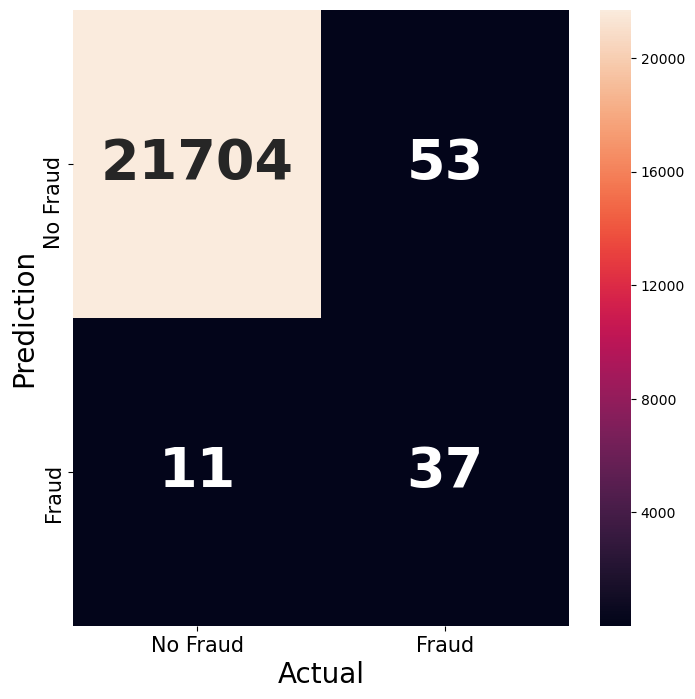

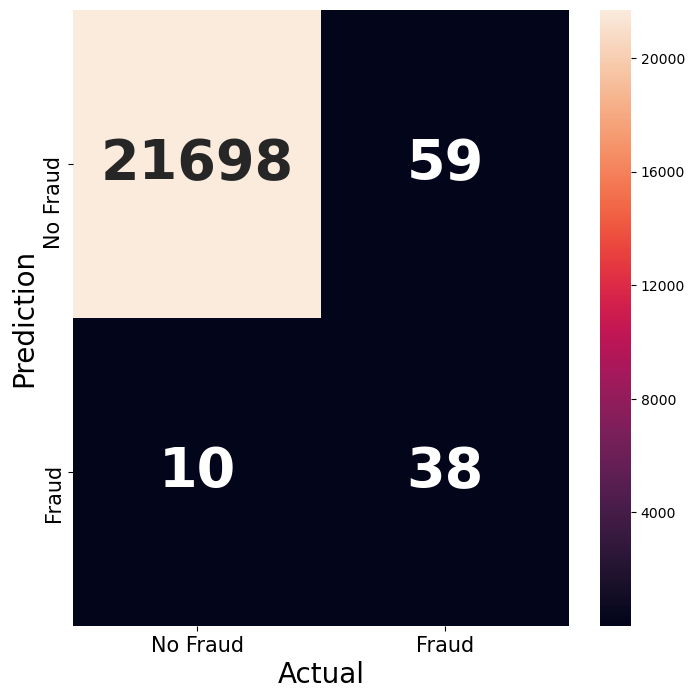

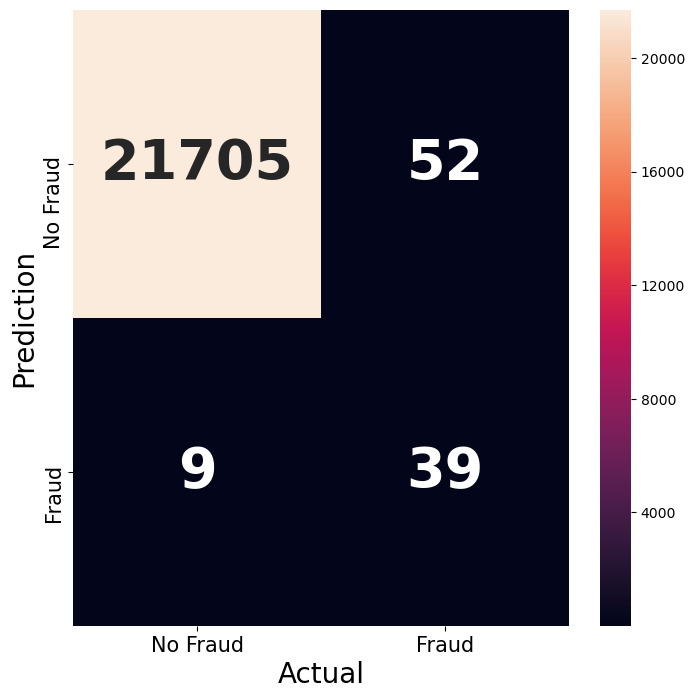

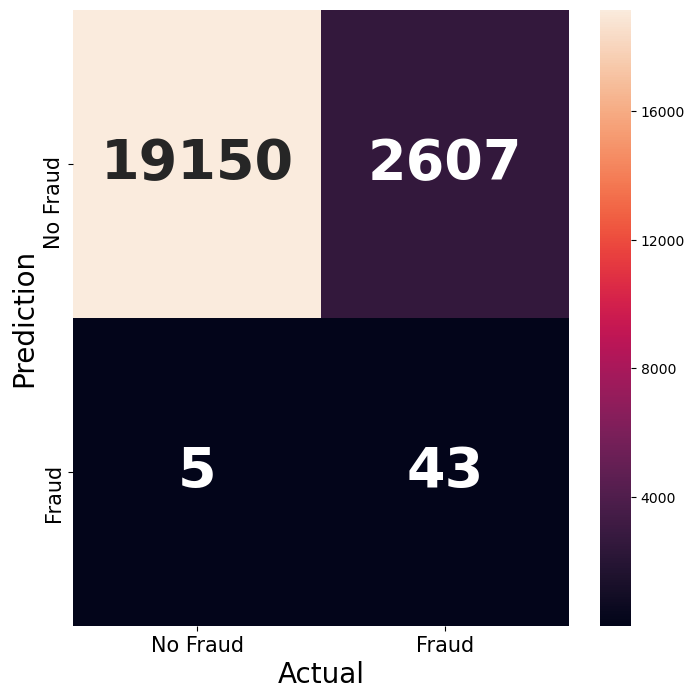

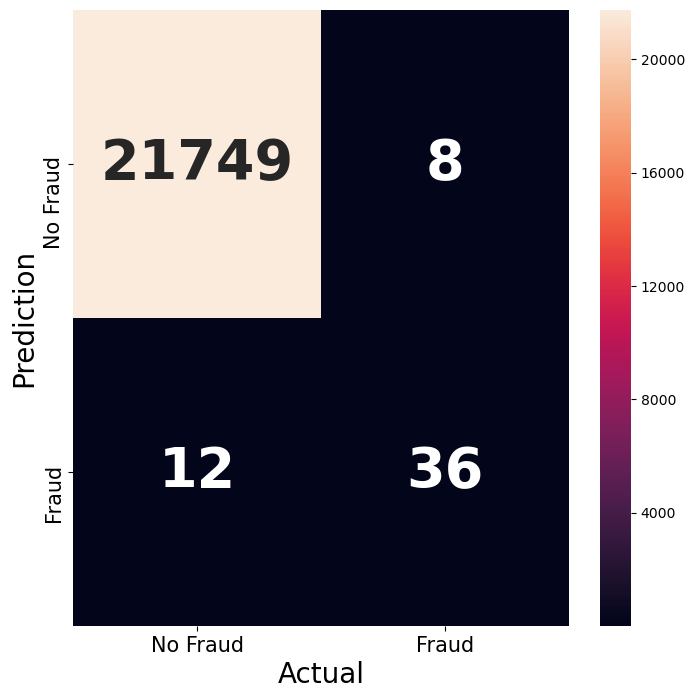

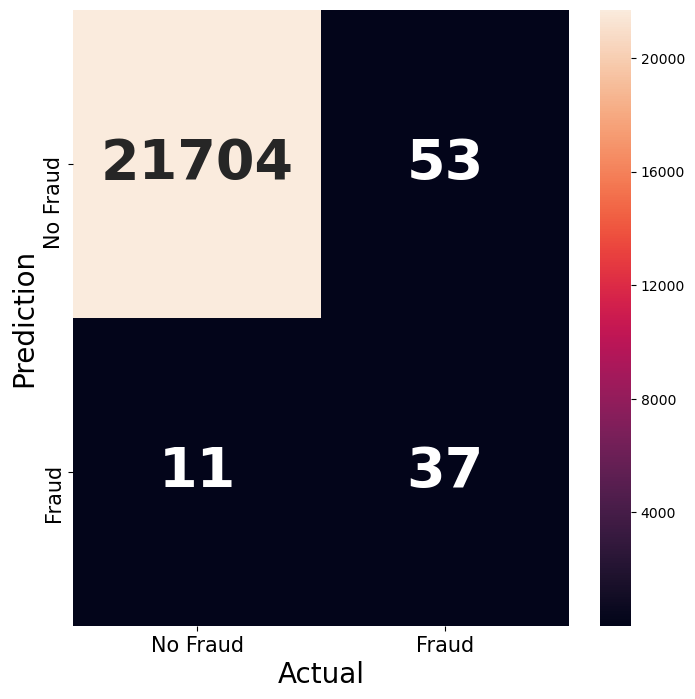

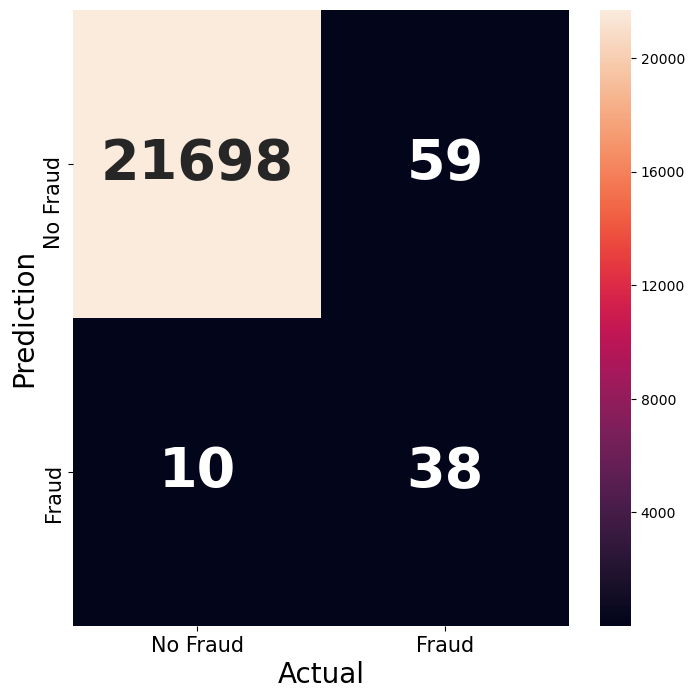

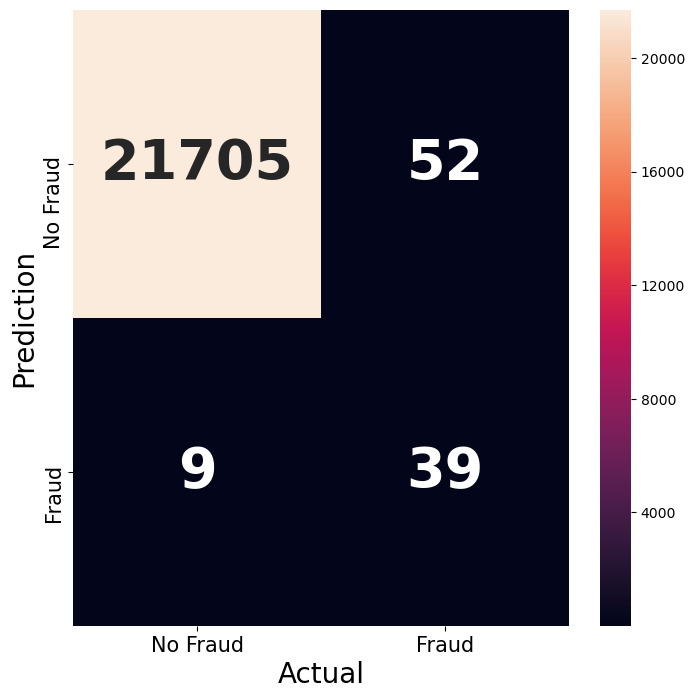

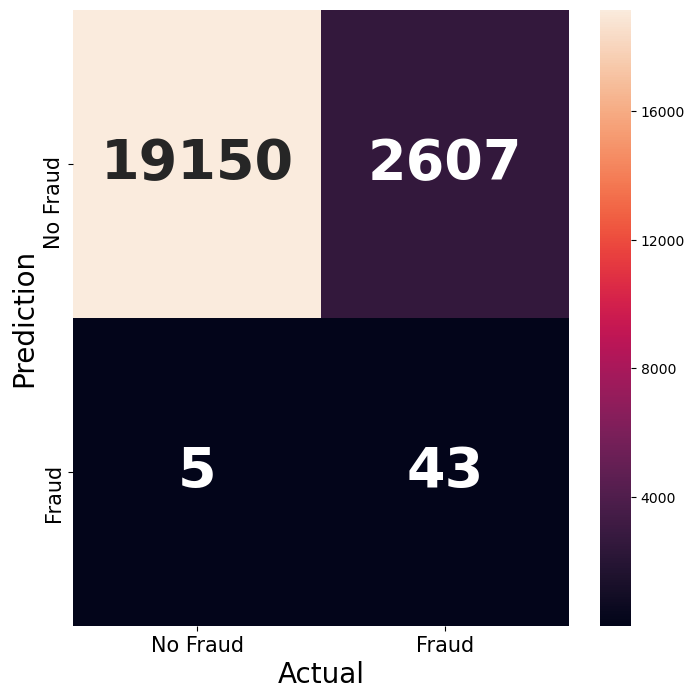

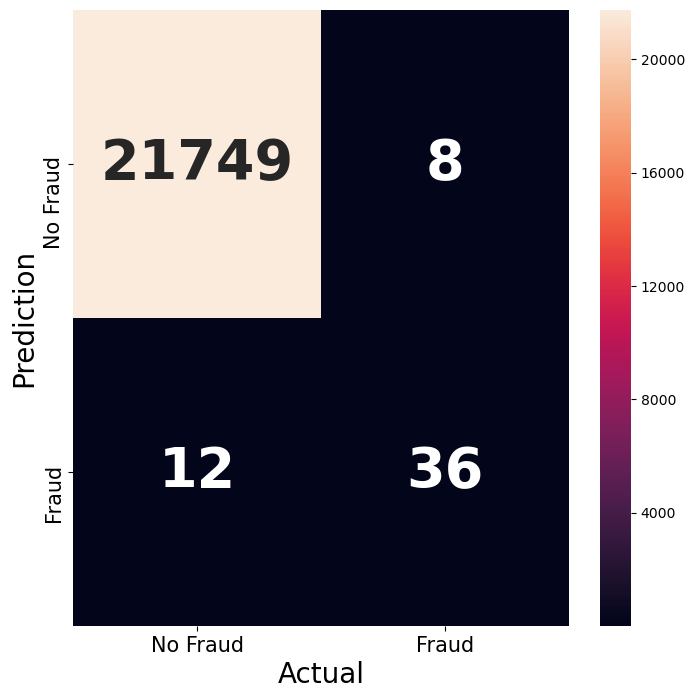

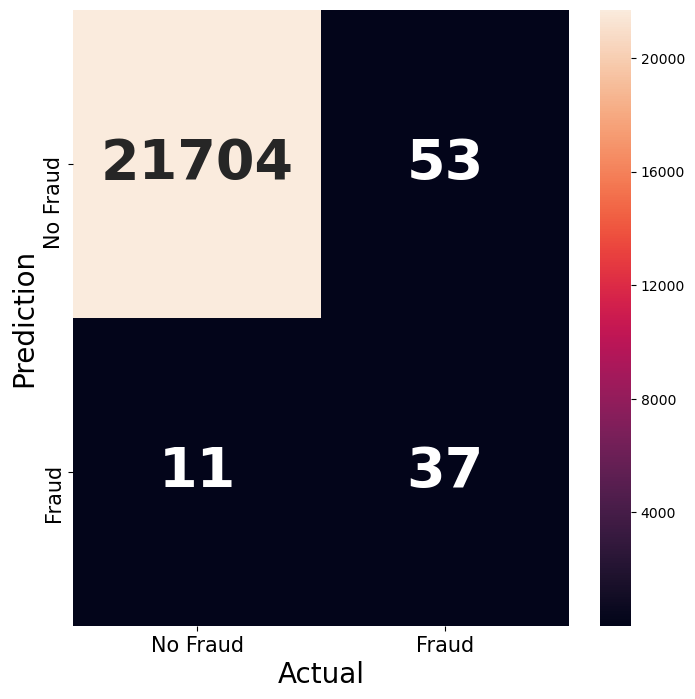

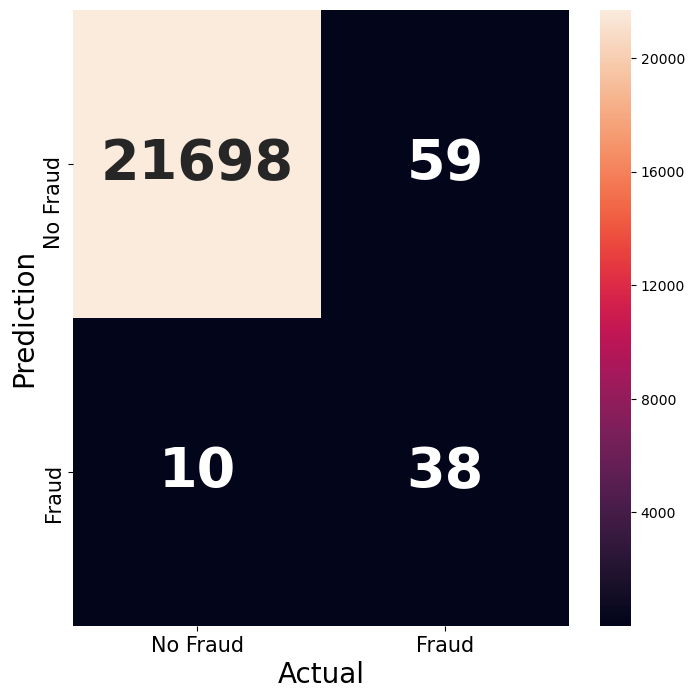

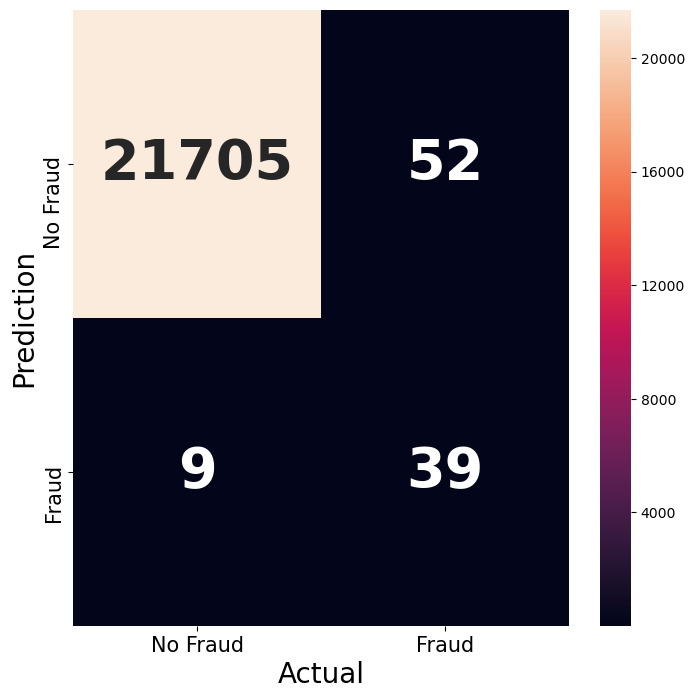

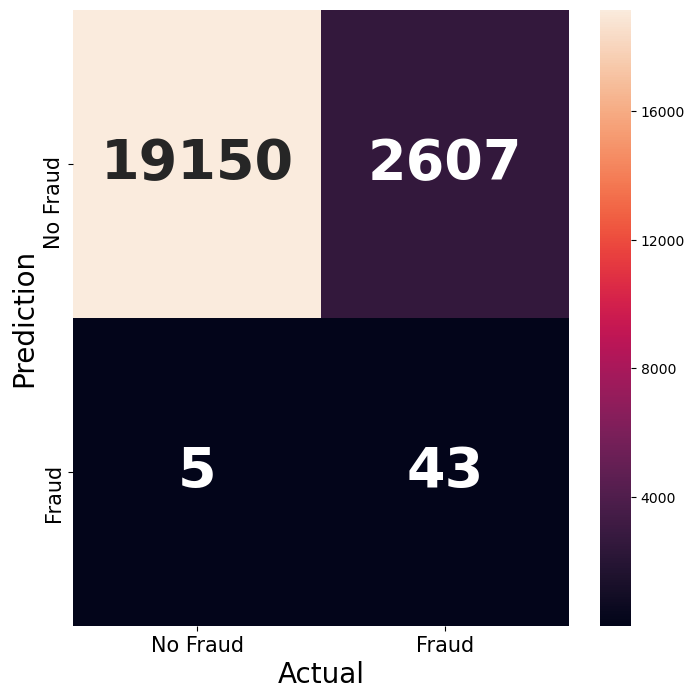

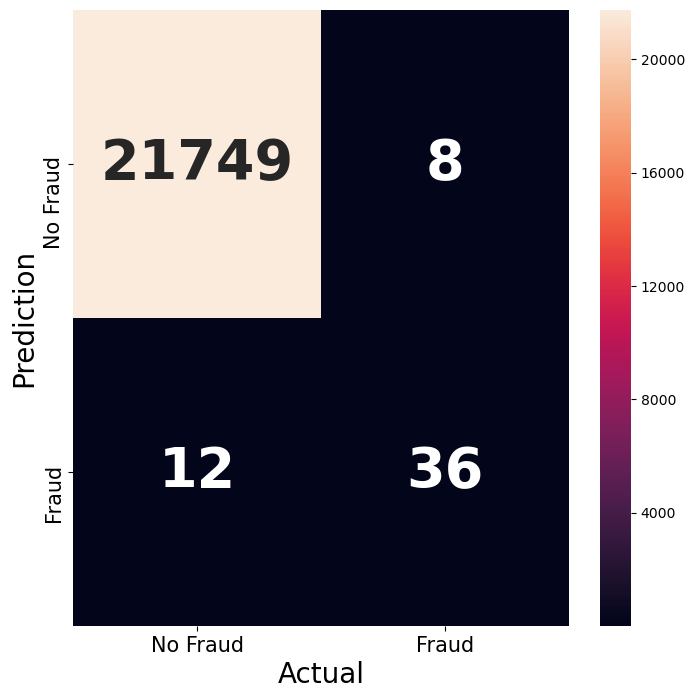

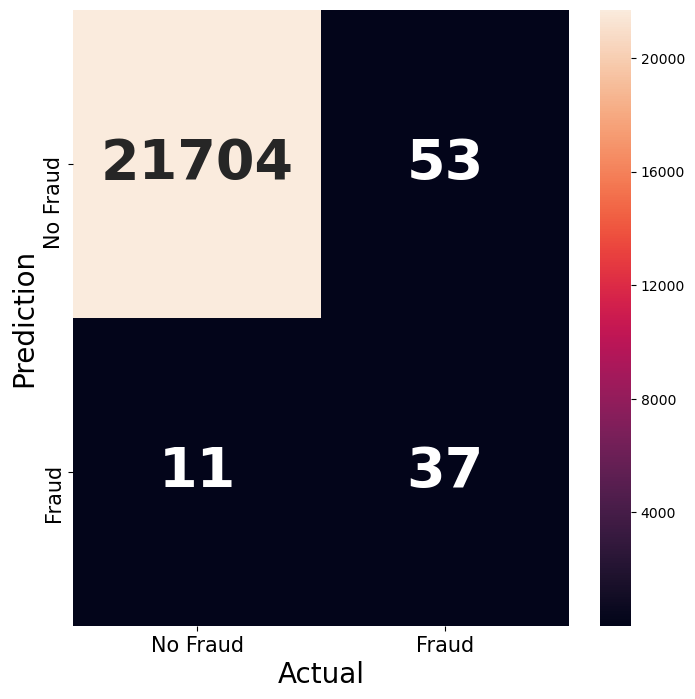

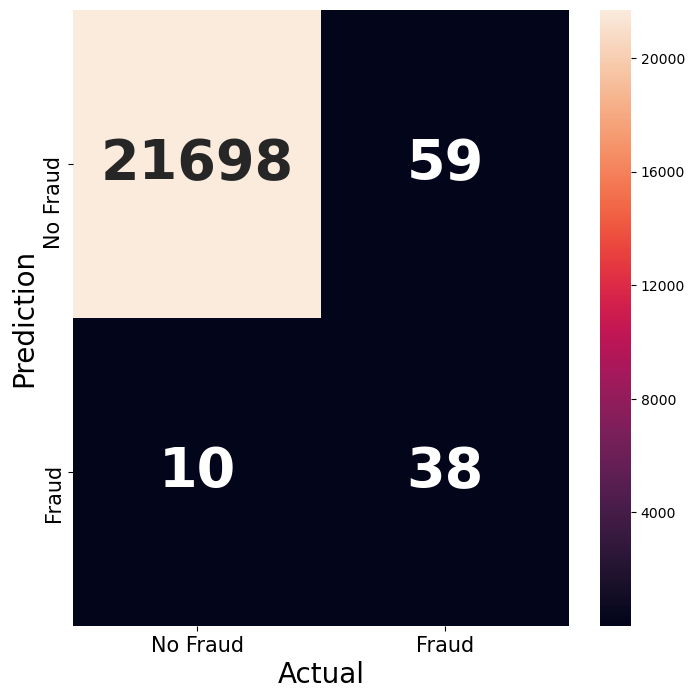

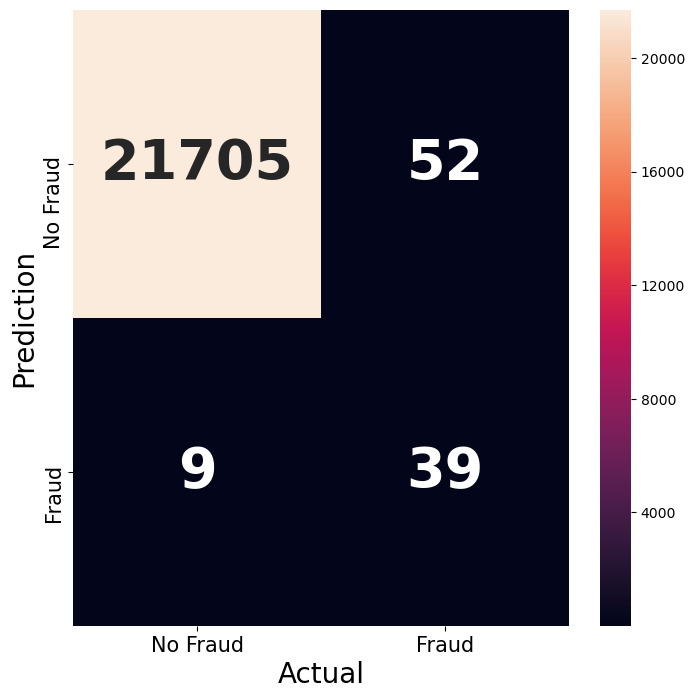

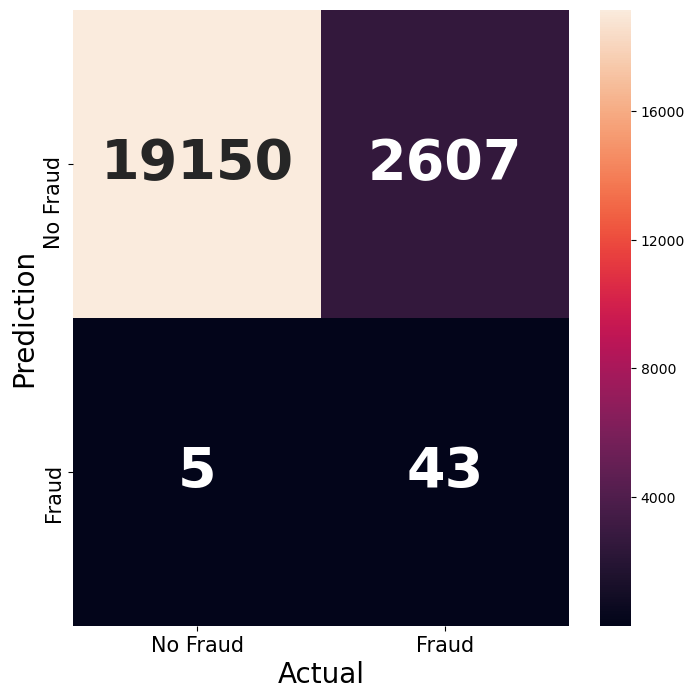

In [31]:
lr = [0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5]
md = [20, 20, 10, 10, 20, 20, 20, 20]
mf = ['log2', 'log2', 'sqrt', 'sqrt', 'log2', 'log2', 'log2', 'log2']
ne = [50, 100, 50, 100, 50, 100, 50, 100]
r = 20
for i in range(5):
    print('GridSearchCV Rank: ', i+1)
    print('GradientBoostingClassifier(n_estimators=', ne[i], 'learning_rate=', lr[i], ', max_depth=', md[i], ', max_features=', mf[i], ', random_state=', r, ')')
    print()
    print('No Balancing')
    gb = GradientBoostingClassifier(n_estimators=ne[i], learning_rate=lr[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred))
    print('Precision = ', precision_score(y_test, y_pred))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('SMOTE')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_smo, y_smo)
    y_pred_smo = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_smo))
    print('Precision = ', precision_score(y_test, y_pred_smo))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_smo), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('ADASYN')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_ada, y_ada)
    y_pred_ada = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_ada))
    print('Precision = ', precision_score(y_test, y_pred_ada))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('SMOTE+Tomek')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_st, y_st)
    y_pred_st = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_st))
    print('Precision = ', precision_score(y_test, y_pred_st))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_st), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print('Random Undersampling')
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r)
    dt.fit(X_ru, y_ru)
    y_pred_ru = dt.predict(X_test)
    print('Recall = ', recall_score(y_test, y_pred_ru))
    print('Precision = ', precision_score(y_test, y_pred_ru))
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_ru), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Fraud', 'Fraud']
    ylabels = ['No Fraud', 'Fraud']
    ax.set_xticklabels(labels, fontsize=15);
    ax.set_yticklabels(ylabels, fontsize=15);
    ax.set_ylabel('Prediction', fontsize=20);
    ax.set_xlabel('Actual', fontsize=20)
    print()
    print()
    print()

## Precision-Recall Curves for best Decision Tree Models

For each training set, plot the Precision-Recall curves for the best 5 decision tree models from the "Find the best decision tree for each training set" section of the "CreditCardFraud_Recall_GridSearchCV" file. Also calculate the Area Under the Precision Recall Curve (AUCPR).

GridSearchCV Rank:  1
DecisionTreeClassifier(class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , min_samples_split= 2 , random_state= 20 )

No Balancing
AUCPR =  0.6515340195402978


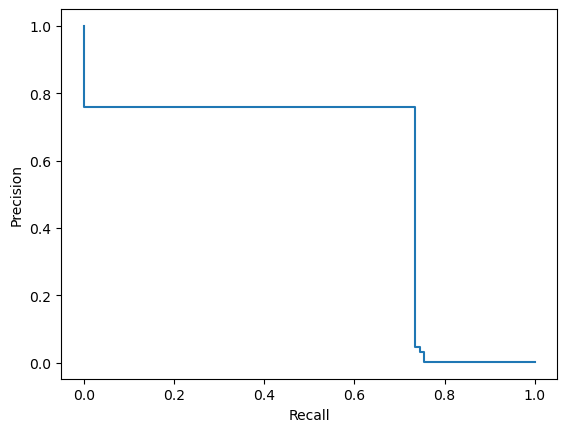


SMOTE
AUCPR =  0.25759420354901874


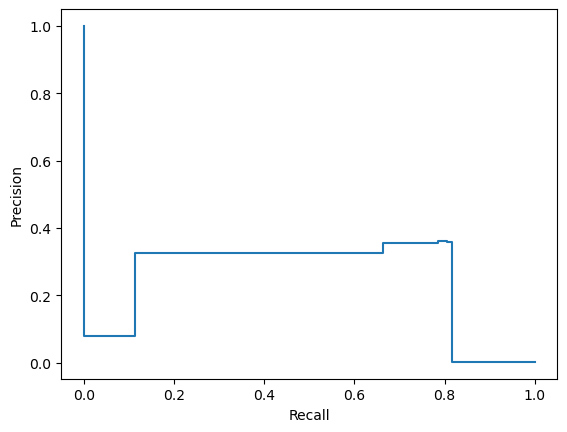


ADASYN
AUCPR =  0.2622013101178328


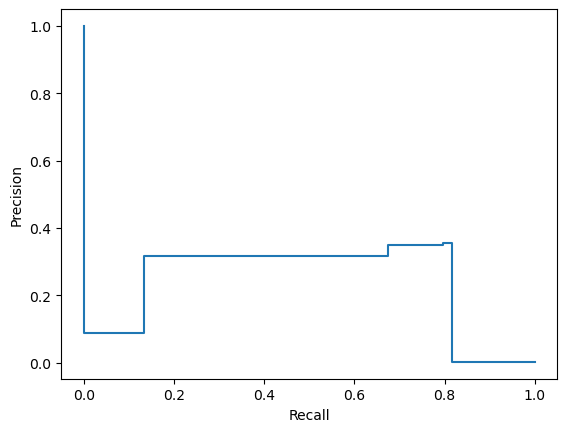


SMOTE+ENN
AUCPR =  0.25759420354901874


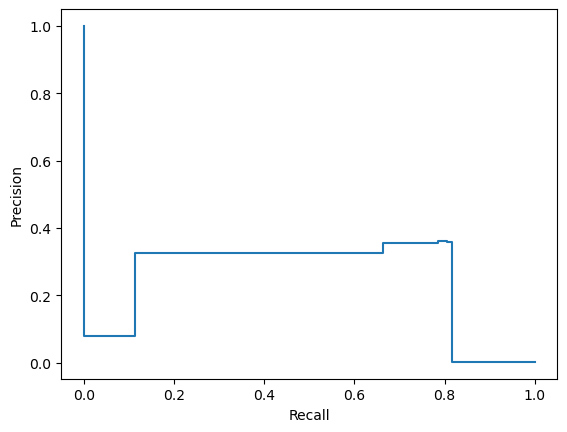


Random Undersampling
AUCPR =  0.46184762526029194


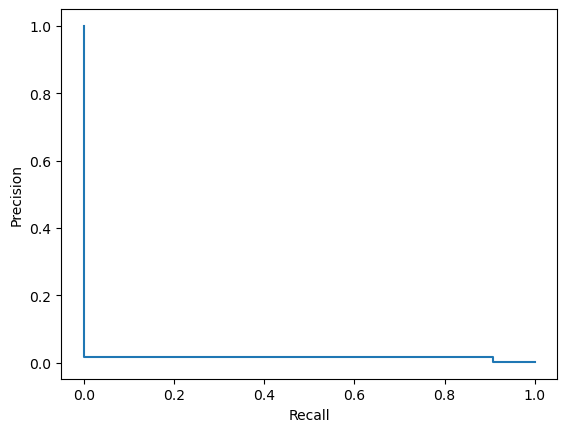




GridSearchCV Rank:  2
DecisionTreeClassifier(class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , min_samples_split= 2 , random_state= 20 )

No Balancing
AUCPR =  0.652741756313885


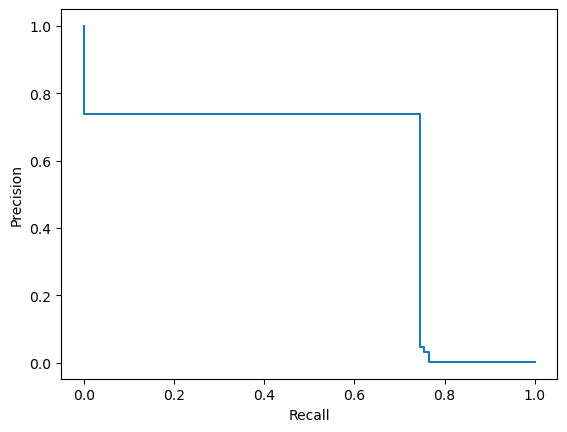


SMOTE
AUCPR =  0.25773057196504623


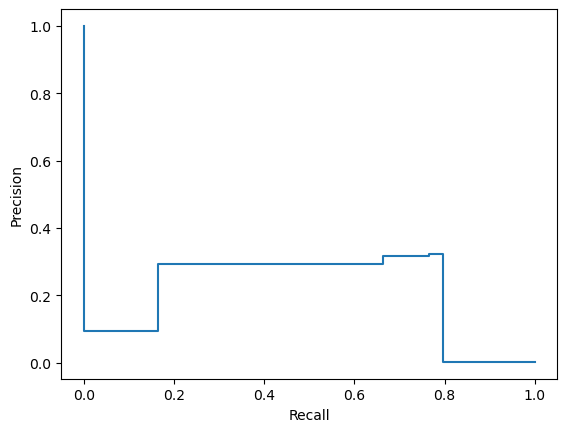


ADASYN
AUCPR =  0.3294995052630818


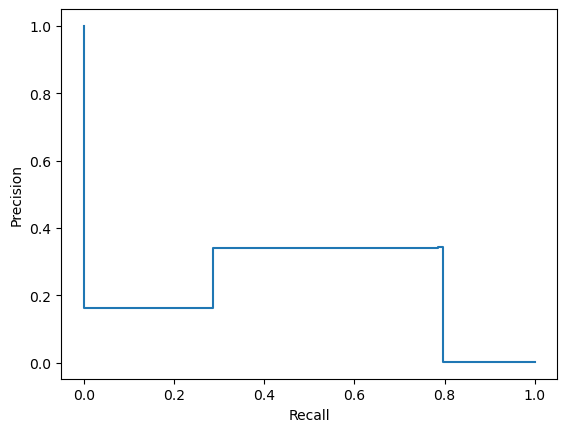


SMOTE+ENN
AUCPR =  0.25773057196504623


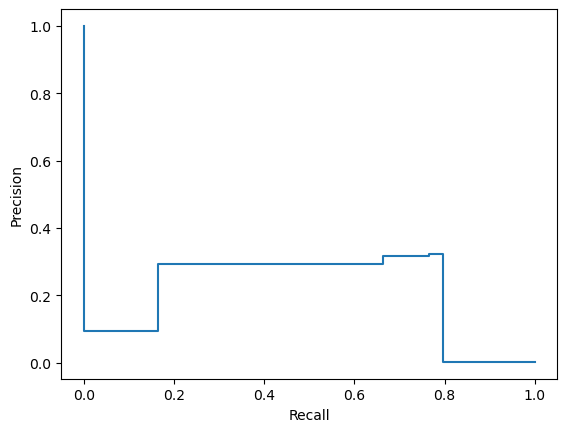


Random Undersampling
AUCPR =  0.46776888850576276


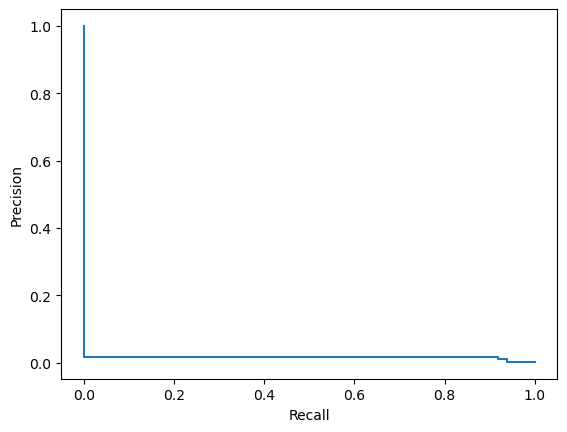




GridSearchCV Rank:  3
DecisionTreeClassifier(class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , min_samples_split= 5 , random_state= 20 )

No Balancing
AUCPR =  0.6559722682763749


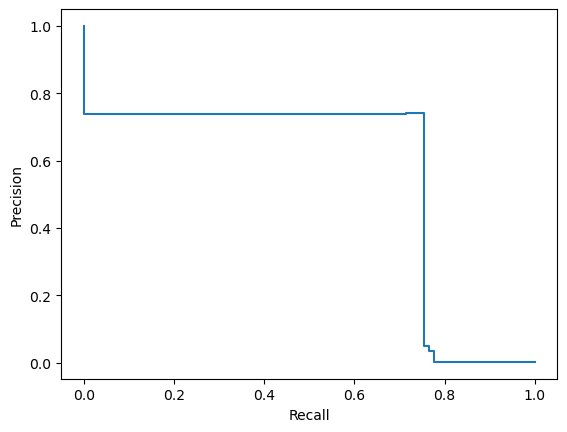


SMOTE
AUCPR =  0.2719405075518003


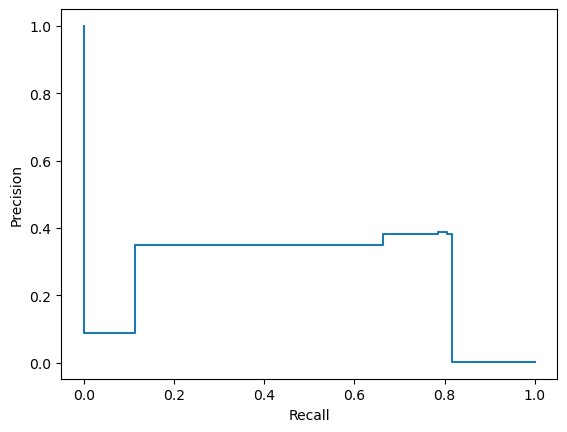


ADASYN
AUCPR =  0.2588718229589224


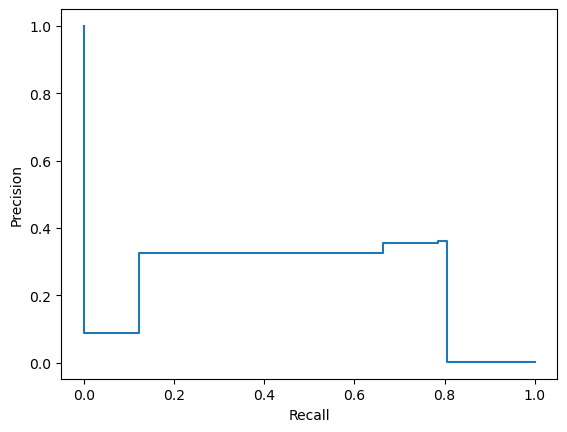


SMOTE+ENN
AUCPR =  0.2719405075518003


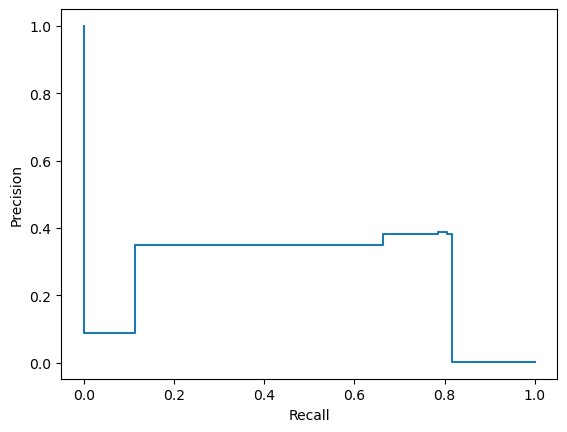


Random Undersampling
AUCPR =  0.4476690564591799


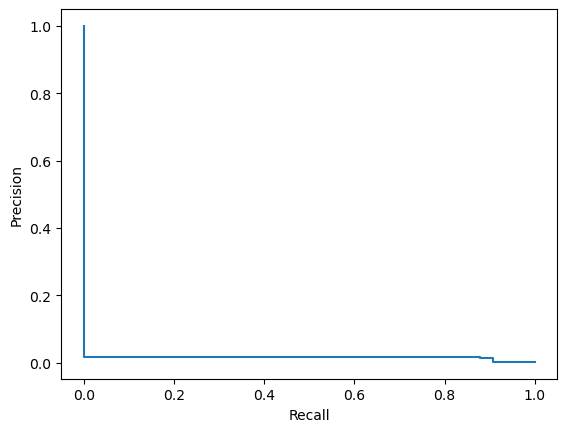




GridSearchCV Rank:  4
DecisionTreeClassifier(class_weight= {0: 0.95, 1: 0.05} , max_depth= 20 , min_samples_split= 2 , random_state= 20 )

No Balancing
AUCPR =  0.5980732698902258


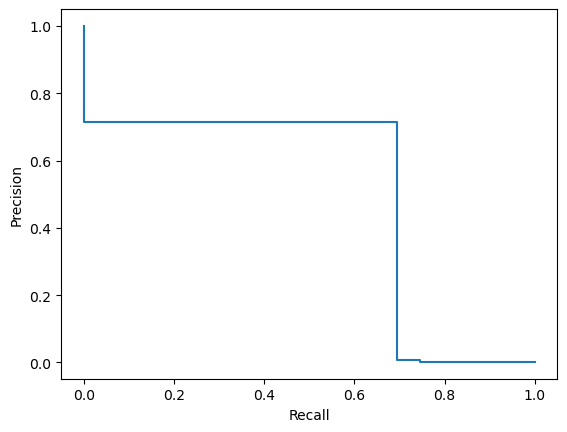


SMOTE
AUCPR =  0.47472611590068303


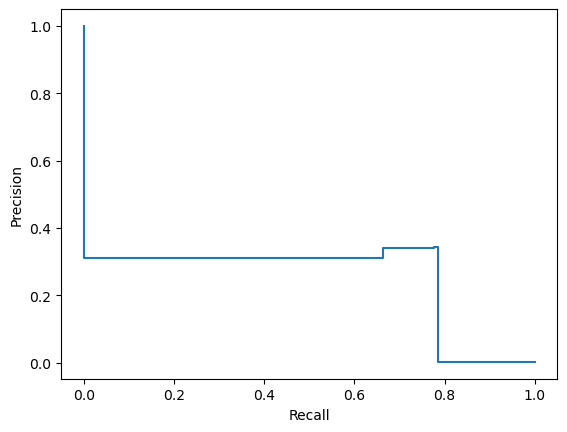


ADASYN
AUCPR =  0.5104017824120131


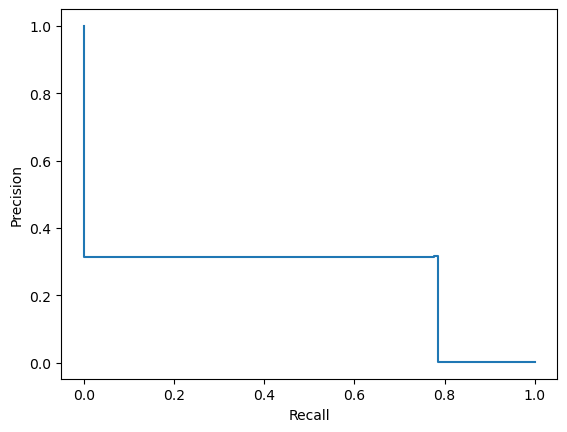


SMOTE+ENN
AUCPR =  0.47472611590068303


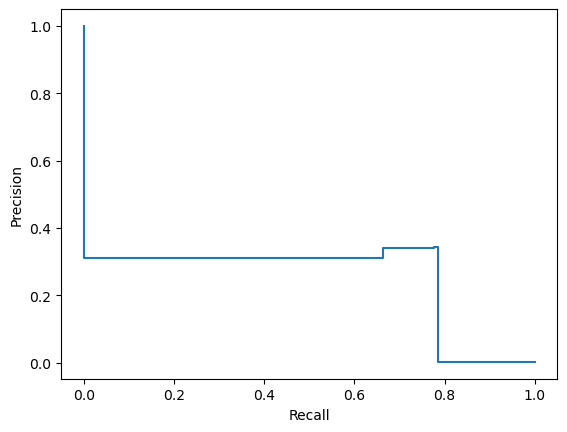


Random Undersampling
AUCPR =  0.45930116059149306


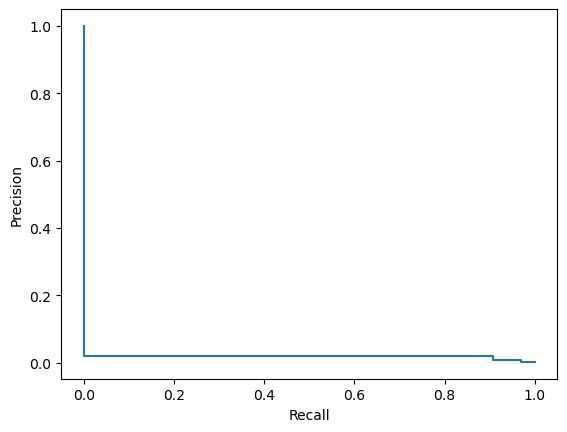




GridSearchCV Rank:  5
DecisionTreeClassifier(class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , min_samples_split= 5 , random_state= 20 )

No Balancing
AUCPR =  0.6400233759502624


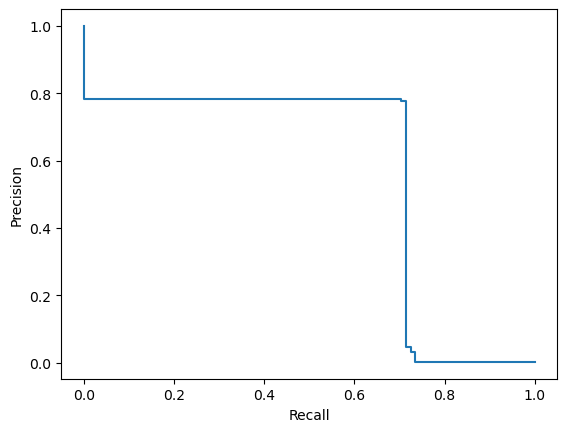


SMOTE
AUCPR =  0.26175429165567093


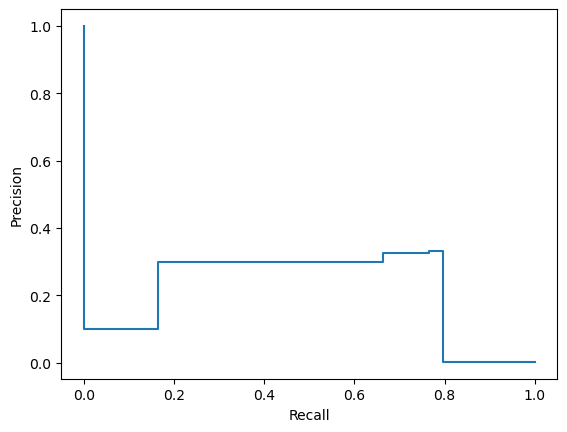


ADASYN
AUCPR =  0.34540734043916377


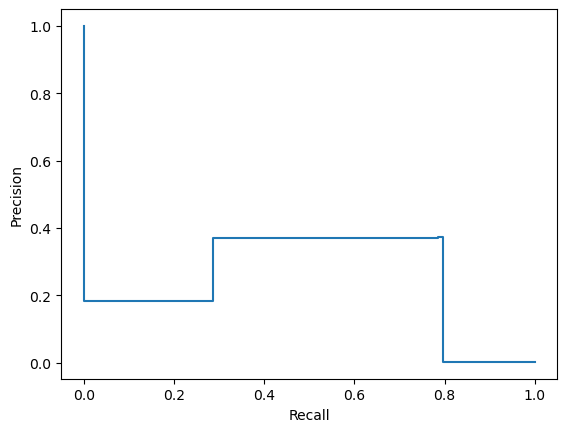


SMOTE+ENN
AUCPR =  0.26175429165567093


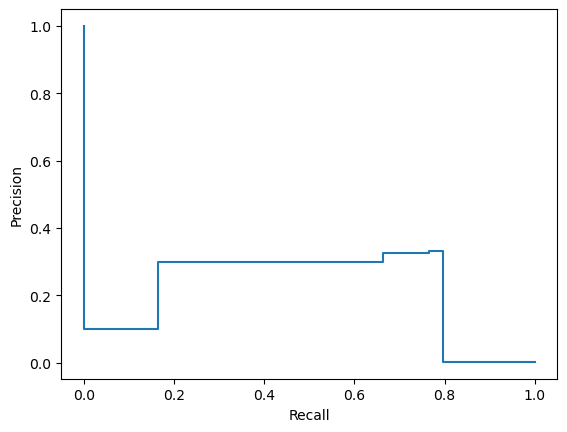


Random Undersampling
AUCPR =  0.45296537449576696


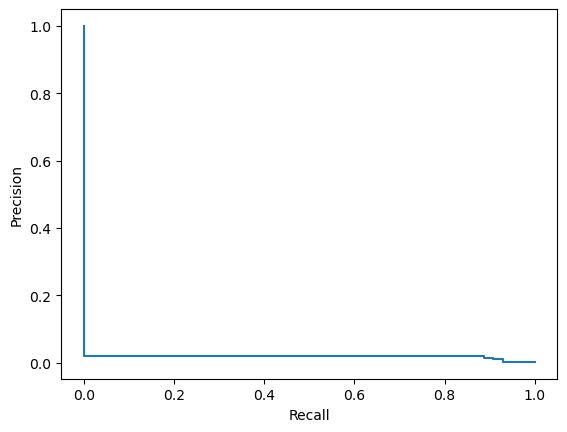

In [30]:
cw = [{0: 0.8, 1: 0.2}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.95, 1: 0.05}, {0: 0.9, 1: 0.1}]
md = [20, 20, 20, 20, 20]
mss = [2, 2, 5, 2, 5]
r = 20
for i in range(5):
    print('GridSearchCV Rank: ', i+1)
    print('DecisionTreeClassifier(class_weight=', cw[i], ', max_depth=', md[i], ', min_samples_split=', mss[i], ', random_state=', r, ')')
    print()
    print('No Balancing')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_test)
    y_pred = y_pred[:, 1]
    y_pred = np.ravel(y_pred)
    #y_pred = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('SMOTE')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_smo, y_smo)
    y_pred_smo = dt.predict_proba(X_test)
    y_pred_smo = y_pred_smo[:, 1]
    y_pred_smo = np.ravel(y_pred_smo)
    #y_pred_smo = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_smo)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('ADASYN')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_ada, y_ada)
    y_pred_ada = dt.predict_proba(X_test)
    y_pred_ada = y_pred_ada[:, 1]
    y_pred_ada = np.ravel(y_pred_ada)
    #y_pred_ada = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_ada)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('SMOTE+ENN')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_st, y_st)
    y_pred_st = dt.predict_proba(X_test)
    y_pred_st = y_pred_st[:, 1]
    y_pred_st = np.ravel(y_pred_st)
    #y_pred_st = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_st)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('Random Undersampling')
    dt = DecisionTreeClassifier(class_weight=cw[i], max_depth=md[i], min_samples_split=mss[i], random_state=r)
    dt.fit(X_ru, y_ru)
    y_pred_ru = dt.predict_proba(X_test)
    y_pred_ru = y_pred_ru[:, 1]
    y_pred_ru = np.ravel(y_pred_ru)
    #y_pred_ru = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_ru)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print()
    print()

## Precision-Recall curves for best Random Forest Models

For each training set, plot the Precision-Recall curves for the best 5 random forest models from the "Find the best decision tree for each training set" section of the "CreditCardFraud_Recall_GridSearchCV" file. Also calculate the Area Under the Precision Recall Curve (AUCPR).

GridSearchCV Rank:  1
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= sqrt , random_state= 20 )

No Balancing
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.8259103188127747


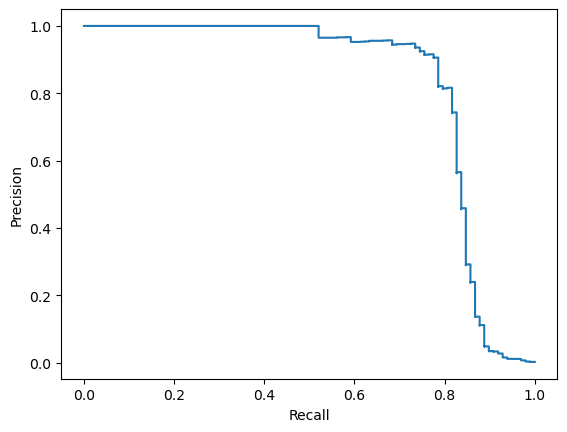


SMOTE
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.822842840758448


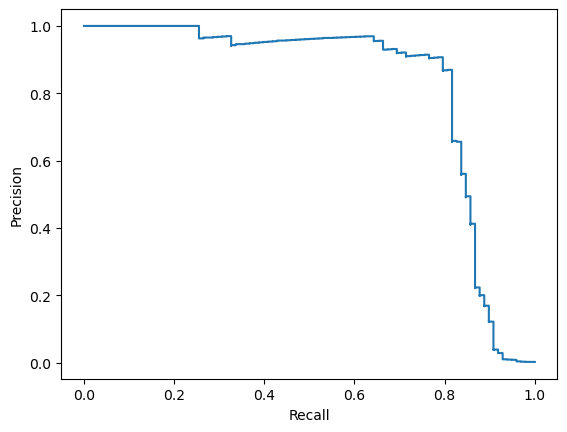


ADASYN
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.8320619830953758


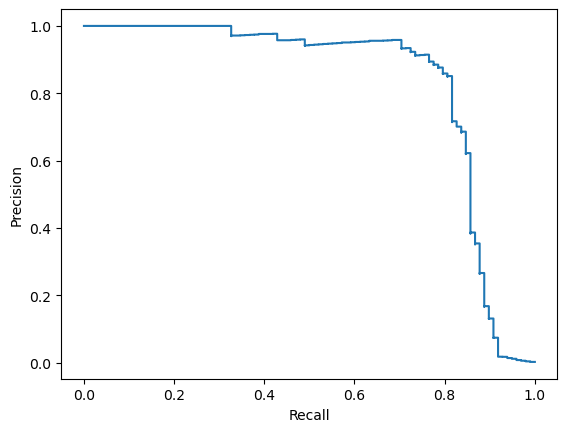


SMOTE+ENN
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.822842840758448


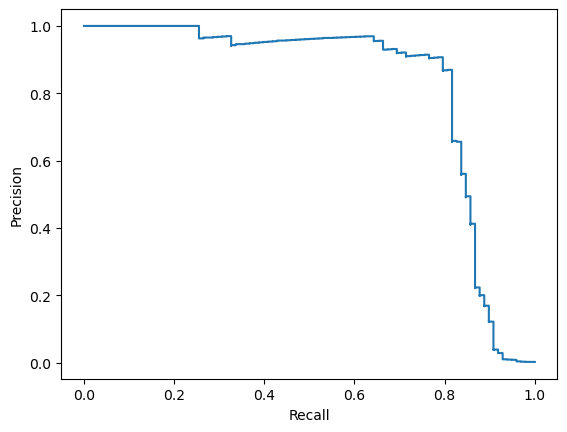


Random Undersampling
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.7598030672911971


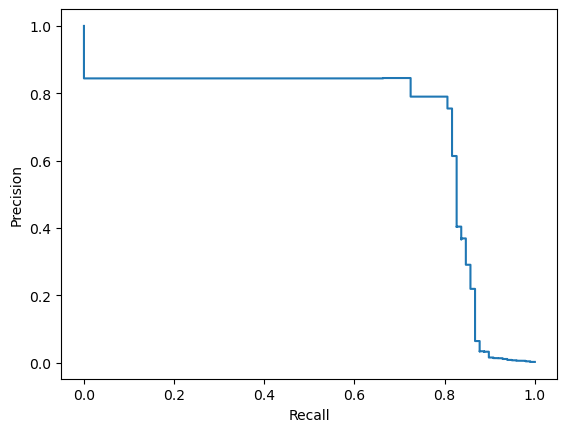




GridSearchCV Rank:  2
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

No Balancing
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.8218329846897052


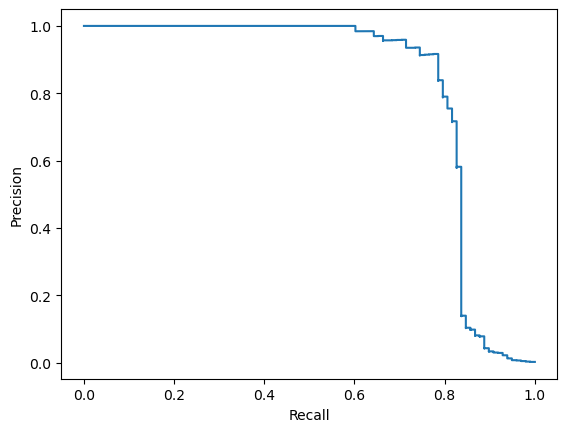


SMOTE
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.829307095569066


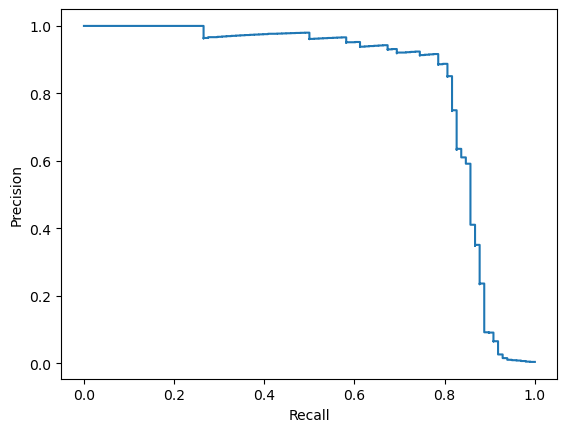


ADASYN
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.8125239798193645


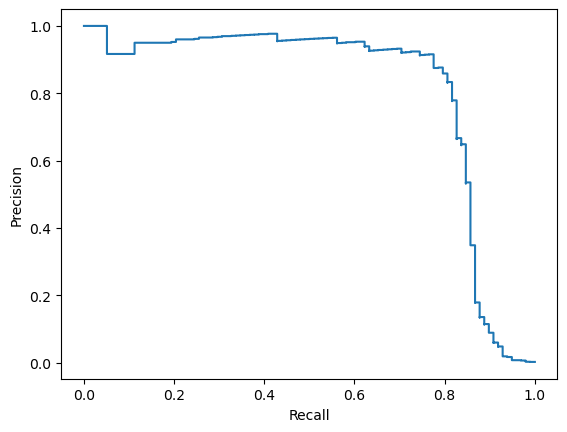


SMOTE+ENN
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.829307095569066


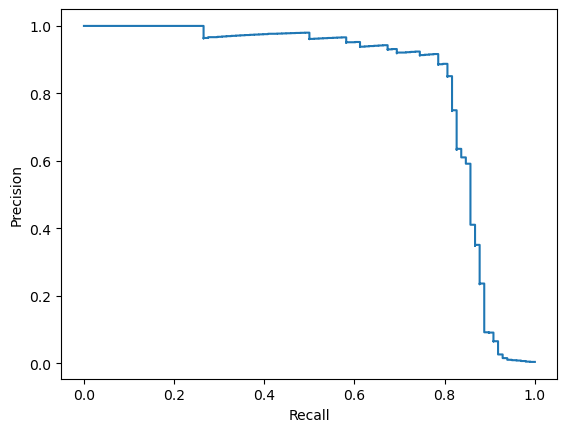


Random Undersampling
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.748859543986626


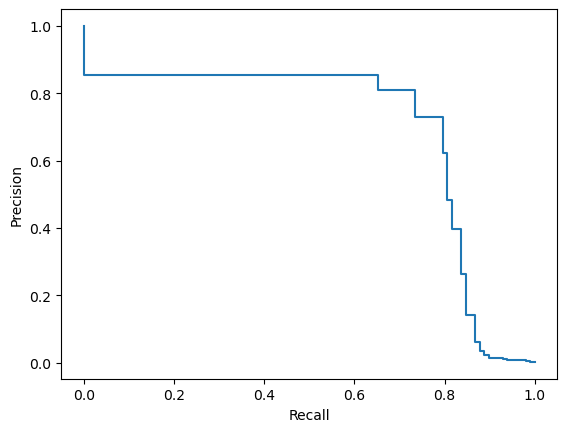




GridSearchCV Rank:  3
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

No Balancing
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.8277270797529955


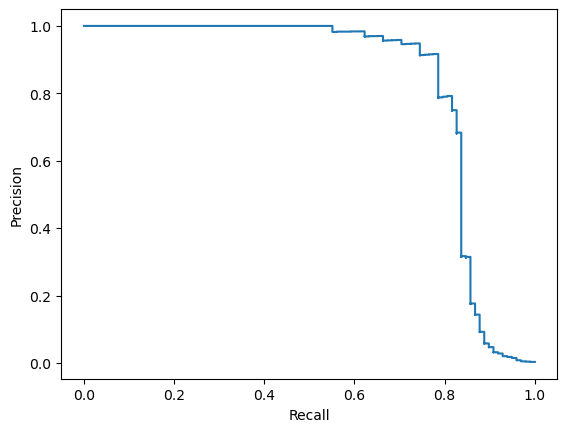


SMOTE
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.830382078850229


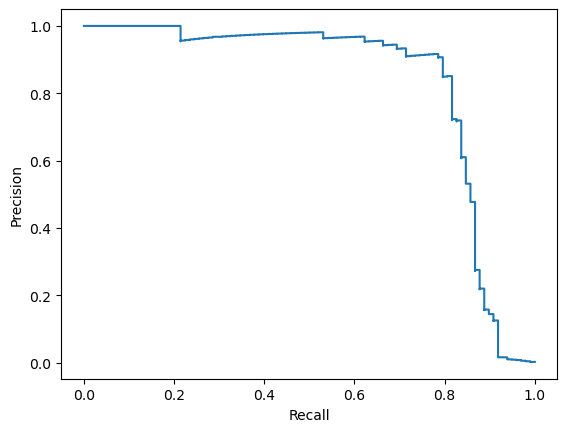


ADASYN
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.803393856271394


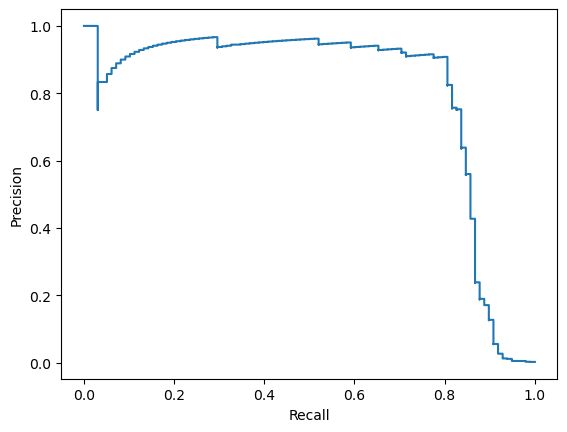


SMOTE+ENN
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.830382078850229


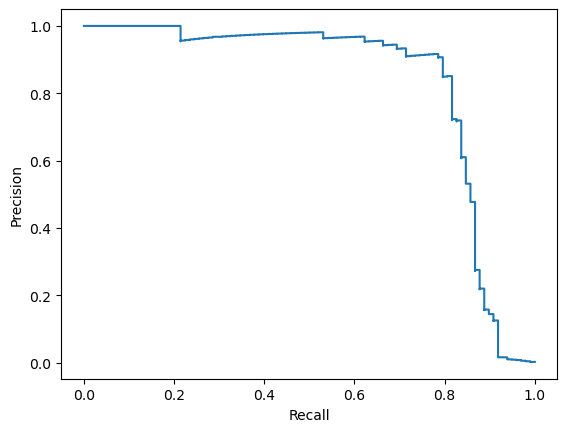


Random Undersampling
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= sqrt , random_state= 20 )

AUCPR =  0.7659080154132724


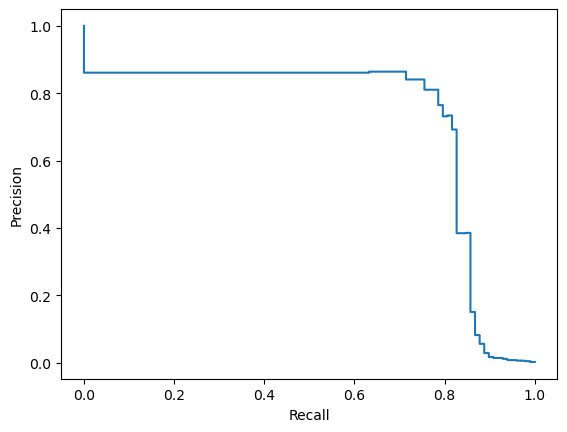




GridSearchCV Rank:  4
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= log2 , random_state= 20 )

No Balancing
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= log2 , random_state= 20 )

AUCPR =  0.8285635036890053


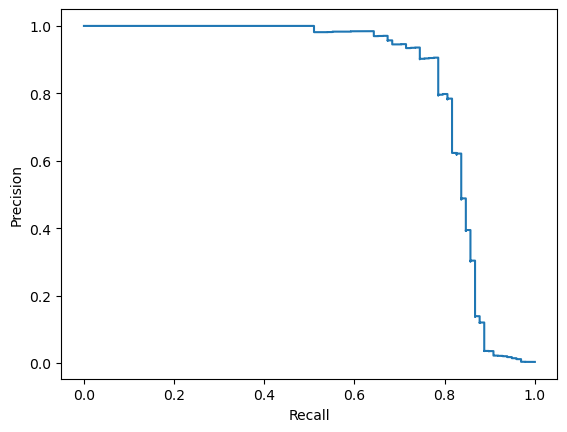


SMOTE
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= log2 , random_state= 20 )

AUCPR =  0.8375768385062132


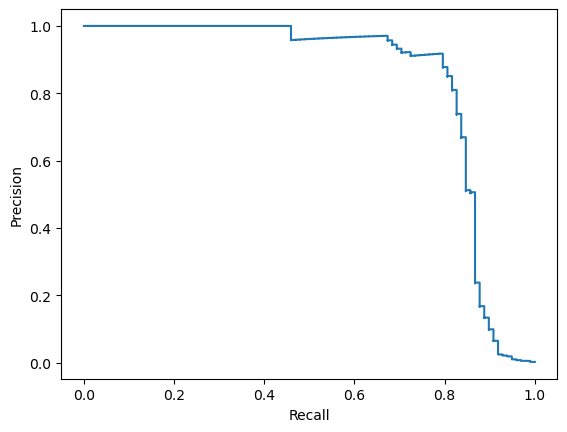


ADASYN
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= log2 , random_state= 20 )

AUCPR =  0.8326868362287598


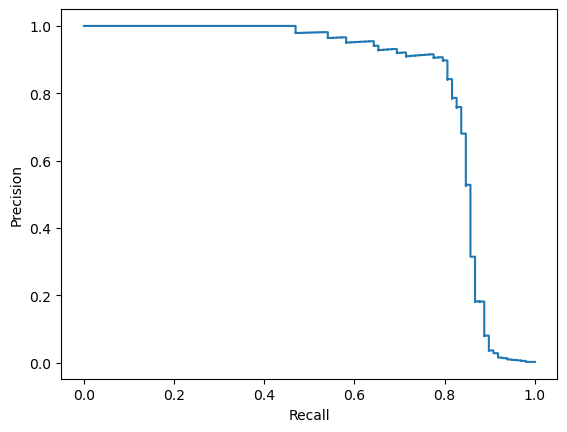


SMOTE+ENN
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= log2 , random_state= 20 )

AUCPR =  0.8375768385062132


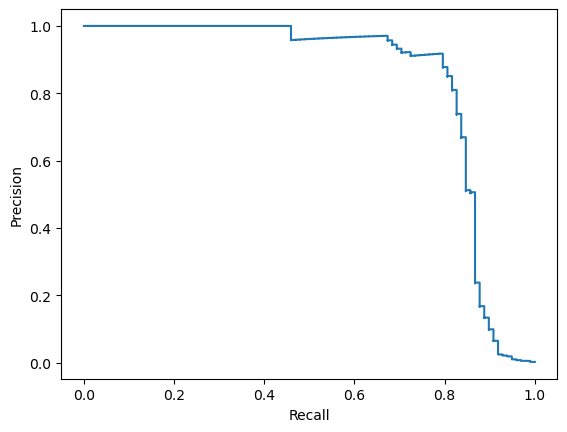


Random Undersampling
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= log2 , random_state= 20 )

AUCPR =  0.7578980997290105


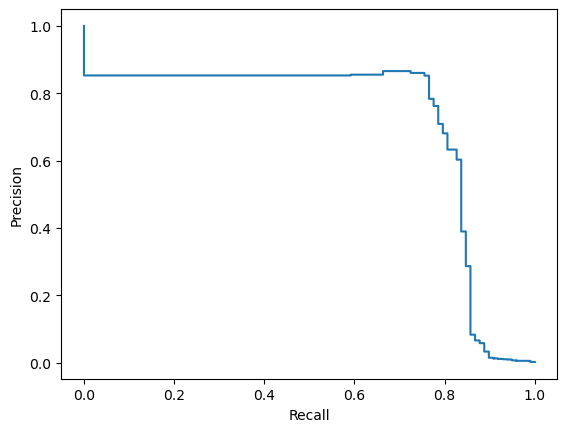




GridSearchCV Rank:  5
RandomForestClassifier(n_estimators= 10 class_weight= {0: 0.95, 1: 0.05} , max_depth= 10 , max_features= sqrt , random_state= 20 )

No Balancing
RandomForestClassifier(n_estimators= 10 class_weight= {0: 0.95, 1: 0.05} , max_depth= 10 , max_features= sqrt , random_state= 20 )

AUCPR =  0.7781859453057182


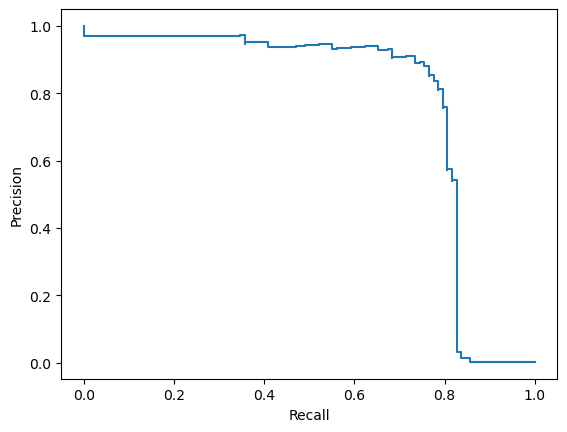


SMOTE
RandomForestClassifier(n_estimators= 10 class_weight= {0: 0.95, 1: 0.05} , max_depth= 10 , max_features= sqrt , random_state= 20 )

AUCPR =  0.8113658670345384


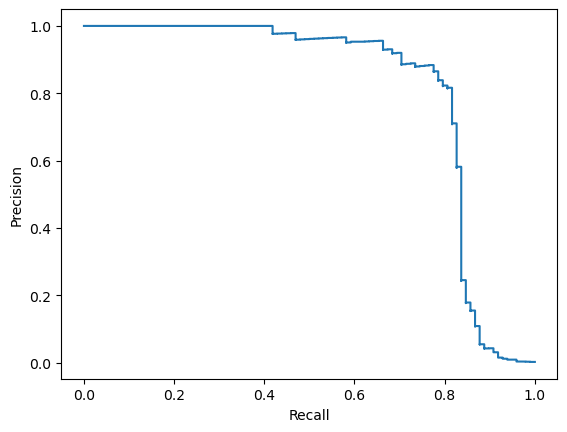


ADASYN
RandomForestClassifier(n_estimators= 10 class_weight= {0: 0.95, 1: 0.05} , max_depth= 10 , max_features= sqrt , random_state= 20 )

AUCPR =  0.7841497766696429


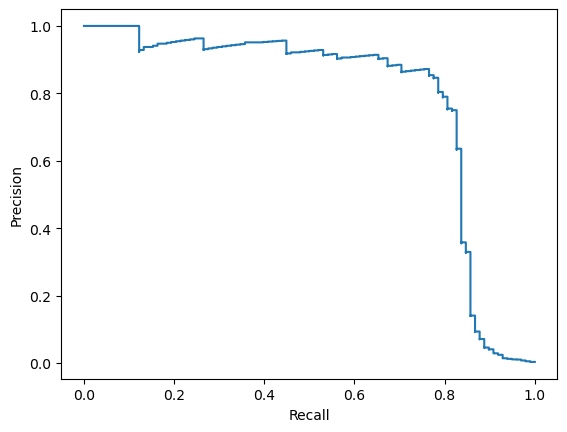


SMOTE+ENN
RandomForestClassifier(n_estimators= 10 class_weight= {0: 0.95, 1: 0.05} , max_depth= 10 , max_features= sqrt , random_state= 20 )

AUCPR =  0.8113658670345384


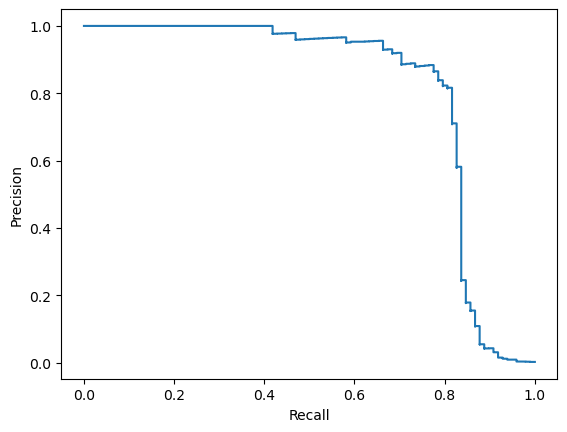


Random Undersampling
RandomForestClassifier(n_estimators= 10 class_weight= {0: 0.95, 1: 0.05} , max_depth= 10 , max_features= sqrt , random_state= 20 )

AUCPR =  0.6105274144380931


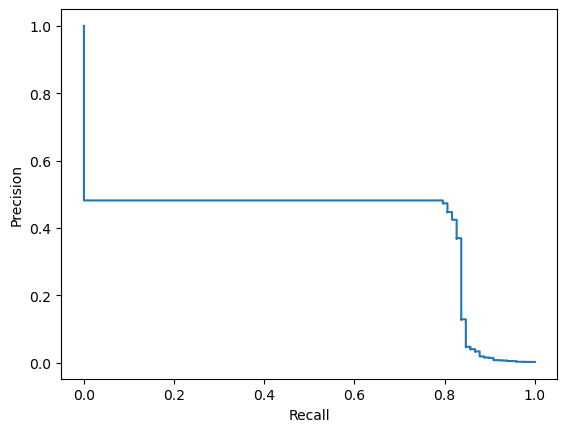

In [37]:
cw = [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.8, 1: 0.2}, {0: 0.8, 1: 0.2}, {0: 0.95, 1: 0.05}]
md = [20, 20, 20, 20, 10]
mf = ['sqrt', 'sqrt', 'sqrt', 'log2', 'sqrt']
ne = [100, 50, 100, 100, 10]
r = 20
for i in range(5):
    print('GridSearchCV Rank: ', i+1)
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mf[i], ', random_state=', r, ')')
    print()
    print('\033[4m'+'No Balancing'+'\033[0m')
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mf[i], ', random_state=', r, ')')
    print()
    rf = RandomForestClassifier(n_estimators=ne[i], class_weight=cw[i], max_depth=md[i], max_features=mf[i], random_state=r, n_jobs=-1)
    rf.fit(X_train, np.ravel(y_train))
    y_pred = rf.predict_proba(X_test)
    y_pred = y_pred[:, 1]
    y_pred = np.ravel(y_pred)
    #y_pred = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('\033[4m'+'SMOTE'+'\033[0m')
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mf[i], ', random_state=', r, ')')
    print()
    rf.fit(X_smo, np.ravel(y_smo))
    y_pred_smo = rf.predict_proba(X_test)
    y_pred_smo = y_pred_smo[:, 1]
    y_pred_smo = np.ravel(y_pred_smo)
    #y_pred_smo = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_smo)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('\033[4m'+'ADASYN'+'\033[0m')
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mf[i], ', random_state=', r, ')')
    print()
    rf.fit(X_ada, np.ravel(y_ada))
    y_pred_ada = rf.predict_proba(X_test)
    y_pred_ada = y_pred_ada[:, 1]
    y_pred_ada = np.ravel(y_pred_ada)
    #y_pred_ada = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_ada)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('\033[4m'+'SMOTE+ENN'+'\033[0m')
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mf[i], ', random_state=', r, ')')
    print()
    rf.fit(X_st, np.ravel(y_st))
    y_pred_st = rf.predict_proba(X_test)
    y_pred_st = y_pred_st[:, 1]
    y_pred_st = np.ravel(y_pred_st)
    #y_pred_st = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_st)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('\033[4m'+'Random Undersampling'+'\033[0m')
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mf[i], ', random_state=', r, ')')
    print()
    rf.fit(X_ru, np.ravel(y_ru))
    y_pred_ru = rf.predict_proba(X_test)
    y_pred_ru = y_pred_ru[:, 1]
    y_pred_ru = np.ravel(y_pred_ru)
    #y_pred_ru = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_ru)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print()
    print()

## Precision-Recall curves for best Gradient Boosting Tree models

For each training set, plot the Precision-Recall curves for the best 5 gradient boosting tree models from the "Find the best decision tree for each training set" section of the "CreditCardFraud_Recall_GridSearchCV" file. Also calculate the Area Under the Precision Recall Curve (AUCPR).

In [2]:
lr = [0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5]
md = [20, 20, 10, 10, 20, 20, 20, 20]
mf = [np.log2(30)/30, np.log2(30)/30, np.sqrt(30)/30, np.sqrt(30)/30, np.log2(30)/30, np.log2(30)/30, np.log2(30)/30, np.log2(30)/30]
ne = [50, 100, 50, 100, 50, 100, 50, 100]
r = 20
for i in range(8):
    print('GridSearchCV Rank: ', i+1)
    print('XGBClassifier(n_estimators=', ne[i], 'learning_rate=', lr[i], ', max_depth=', md[i], ', colsample_bynode=', mf[i], ', eval_metric= \'aucpr\'', ', random_state=', r, ')')
    print()
    print('No Balancing')
#    gb = GradientBoostingClassifier(n_estimators=ne[i], learning_rate=lr[i], max_depth=md[i], max_features=mf[i], random_state=r)
    gb = XGBClassifier(eta=lr[i], max_depth=md[i], colsample_bynode=mf[i], n_estimators=ne[i], eval_metric='aucpr')
#    gbcv = GridSearchCV(estimator=gb, )
    gb.fit(X_train, np.ravel(y_train))
    y_pred = gb.predict_proba(X_test)
    y_pred = y_pred[:, 1]
    y_pred = np.ravel(y_pred)
    #y_pred = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('XGBClassifier(n_estimators=', ne[i], 'learning_rate=', lr[i], ', max_depth=', md[i], ', colsample_bynode=', mf[i], ', eval_metric= \'aucpr\'', ', random_state=', r, ')')
    print('SMOTE')
    gb.fit(X_smo, np.ravel(y_smo))
    y_pred_smo = gb.predict_proba(X_test)
    y_pred_smo = y_pred_smo[:, 1]
    y_pred_smo = np.ravel(y_pred_smo)
    #y_pred_smo = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_smo)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('XGBClassifier(n_estimators=', ne[i], 'learning_rate=', lr[i], ', max_depth=', md[i], ', colsample_bynode=', mf[i], ', eval_metric= \'aucpr\'', ', random_state=', r, ')')
    print('ADASYN')
    gb.fit(X_ada, np.ravel(y_ada))
    y_pred_ada = gb.predict_proba(X_test)
    y_pred_ada = y_pred_ada[:, 1]
    y_pred_ada = np.ravel(y_pred_ada)
    #y_pred_ada = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_ada)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('XGBClassifier(n_estimators=', ne[i], 'learning_rate=', lr[i], ', max_depth=', md[i], ', colsample_bynode=', mf[i], ', eval_metric= \'aucpr\'', ', random_state=', r, ')')
    print('SMOTE+ENN')
    gb.fit(X_st, np.ravel(y_st))
    y_pred_st = gb.predict_proba(X_test)
    y_pred_st = y_pred_st[:, 1]
    y_pred_st = np.ravel(y_pred_st)
    #y_pred_st = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_st)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print('XGBClassifier(n_estimators=', ne[i], 'learning_rate=', lr[i], ', max_depth=', md[i], ', colsample_bynode=', mf[i], ', eval_metric= \'aucpr\'', ', random_state=', r, ')')
    print('Random Undersampling')
    gb.fit(X_ru, np.ravel(y_ru))
    y_pred_ru = gb.predict_proba(X_test)
    y_pred_ru = y_pred_ru[:, 1]
    y_pred_ru = np.ravel(y_pred_ru)
    #y_pred_ru = dt.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_ru)
    print('AUCPR = ', auc(recall, precision))
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    print()
    print()
    print()

NameError: name 'np' is not defined

In [18]:
lr = [0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5]
md = [20, 20, 10, 10, 20, 20, 20, 20]
mf = [np.log2(30)/30, np.log2(30)/30, np.sqrt(30)/30, np.sqrt(30)/30, np.log2(30)/30, np.log2(30)/30, np.log2(30)/30, np.log2(30)/30]
ne = [50, 100, 50, 100, 50, 100, 50, 100]
r = 20
for i in range(8):
    print('XGBClassifier(n_estimators=', ne[i], 'learning_rate=', lr[i], ', max_depth=', md[i], ', colsample_bynode=', mf[i], ')')

XGBClassifier(n_estimators= 50 learning_rate= 0.05 , max_depth= 20 , colsample_bynode= 0.1635630198536173 )
XGBClassifier(n_estimators= 100 learning_rate= 0.05 , max_depth= 20 , colsample_bynode= 0.1635630198536173 )
XGBClassifier(n_estimators= 50 learning_rate= 0.1 , max_depth= 10 , colsample_bynode= 0.18257418583505539 )
XGBClassifier(n_estimators= 100 learning_rate= 0.1 , max_depth= 10 , colsample_bynode= 0.18257418583505539 )
XGBClassifier(n_estimators= 50 learning_rate= 0.1 , max_depth= 20 , colsample_bynode= 0.1635630198536173 )
XGBClassifier(n_estimators= 100 learning_rate= 0.1 , max_depth= 20 , colsample_bynode= 0.1635630198536173 )
XGBClassifier(n_estimators= 50 learning_rate= 0.5 , max_depth= 20 , colsample_bynode= 0.1635630198536173 )
XGBClassifier(n_estimators= 100 learning_rate= 0.5 , max_depth= 20 , colsample_bynode= 0.1635630198536173 )


In [19]:
cw = [{0: 0.8, 1: 0.2}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.95, 1: 0.05}, {0: 0.9, 1: 0.1}]
md = [20, 20, 20, 20, 20]
mss = [2, 2, 5, 2, 5]
r = 20
for i in range(5):
    print('DecisionTreeClassifier(class_weight=', cw[i], ', max_depth=', md[i], ', min_samples_split=', mss[i], ', random_state=', r, ')')

DecisionTreeClassifier(class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , min_samples_split= 2 , random_state= 20 )
DecisionTreeClassifier(class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , min_samples_split= 2 , random_state= 20 )
DecisionTreeClassifier(class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , min_samples_split= 5 , random_state= 20 )
DecisionTreeClassifier(class_weight= {0: 0.95, 1: 0.05} , max_depth= 20 , min_samples_split= 2 , random_state= 20 )
DecisionTreeClassifier(class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , min_samples_split= 5 , random_state= 20 )


In [20]:
cw = [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.8, 1: 0.2}, {0: 0.8, 1: 0.2}, {0: 0.95, 1: 0.05}]
md = [20, 20, 20, 20, 10]
mf = ['sqrt', 'sqrt', 'sqrt', 'log2', 'sqrt']
ne = [100, 50, 100, 100, 10]
r = 20
for i in range(5):
    print('RandomForestClassifier(n_estimators=', ne[i], 'class_weight=', cw[i], ', max_depth=', md[i], ', max_features=', mss[i], ', random_state=', r, ')')

RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.9, 1: 0.1} , max_depth= 20 , max_features= 2 , random_state= 20 )
RandomForestClassifier(n_estimators= 50 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= 2 , random_state= 20 )
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= 5 , random_state= 20 )
RandomForestClassifier(n_estimators= 100 class_weight= {0: 0.8, 1: 0.2} , max_depth= 20 , max_features= 2 , random_state= 20 )
RandomForestClassifier(n_estimators= 10 class_weight= {0: 0.95, 1: 0.05} , max_depth= 10 , max_features= 5 , random_state= 20 )
